# Quantitative Trading Strategies
# FX Carry Strategy

## FINM 33150 - 2024

* Baptiste PEPIN

### Import modules

In [1]:
import datetime
import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import quandl
import seaborn as sns

import config

warnings.simplefilter(action='ignore', category=FutureWarning)

sns.set(style="whitegrid")
custom_palette = ['blue', 'green', 'purple', 'red', 'orange']
sns.set_palette(custom_palette)

os.chdir('/Users/baptistepepin/Desktop/MSFM/FINM 33150 - Quantitative Trading Strategies')

%matplotlib inline

### 1. Introduction

An FX carry strategy borrows in a (low-interest-rate) currency and lends in another currency (with high interest rates). This is typically arranged via a cross-currency swap.

In this homework, we will synthesize an approximate PL of weekly traded cross-currency fixed-float swaps from the OIS rates and swap curves, normalized to have a USD notional of US$10MM at the beginning of each week. We assume zero trading costs. For the purpose of our cash flow tracking, we will convert flows to USD, though in some cases doing so is superfluous.

We will first retrieve the data from Quandl and transform it for our purpose. We will then implement the strategy before trying to optimize some of its parameters. Finally, we will analyze the results of our strategy with different sets of parameters, against different benchmarks.

The data we will use is the following:
* FX rates for the dollar versus pound (our borrowing currency) but also for Egyptian Pound, Hungarian Forint, Costa Rican Colon and Romanian Leu (our lending currencies).
* The shortest available rates for UK overnight index swaps (OIS) — series IUDSOIA.
* The swap yield curves associated to the countries for which we retrieved the FX rates.

### 2. Data Manipulation

#### 2.1. Data Collection

We will start by retrieving the data from Quandl. We will use the Quandl Python package to do so. To perform this extraction, one need to get access to the NASDAQ API key and to set it in the code below.

The `fetch_quandl_table` function will download the data and save it in a local folder. If the data has already been downloaded, it will not be downloaded again. Instead, the function will return the path to the local file containing the data.

In [2]:
def grab_quandl_table(
        table_path,
        avoid_download=False,
        replace_existing=False,
        date_override=None,
        allow_old_file=False,
        **kwargs,
):
    root_data_dir = os.path.join(os.getcwd(), "quandl_data_table_downloads")
    data_symlink = os.path.join(root_data_dir, f"{table_path}_latest.zip")
    if avoid_download and os.path.exists(data_symlink):
        print(f"Skipping any possible download of {table_path}")
        return data_symlink

    table_dir = os.path.dirname(data_symlink)
    if not os.path.isdir(table_dir):
        print(f'Creating new data dir {table_dir}')
        os.mkdir(table_dir)

    if date_override is None:
        my_date = datetime.datetime.now().strftime("%Y%m%d")
    else:
        my_date = date_override
    data_file = os.path.join(root_data_dir, f"{table_path}_{my_date}.zip")

    if os.path.exists(data_file):
        file_size = os.stat(data_file).st_size
        if replace_existing or not file_size > 0:
            print(f"Removing old file {data_file} size {file_size}")
        else:
            print(
                f"Data file {data_file} size {file_size} exists already, no need to download"
            )
            return data_file

    dl = quandl.export_table(
        table_path, filename=data_file, api_key=config.QUANDL_API_KEY, **kwargs
    )
    file_size = os.stat(data_file).st_size
    if os.path.exists(data_file) and file_size > 0:
        print(f"Download finished: {file_size} bytes")
        if not date_override:
            if os.path.exists(data_symlink):
                print(f"Removing old symlink")
                os.unlink(data_symlink)
            print(f"Creating symlink: {data_file} -> {data_symlink}")
            os.symlink(
                data_file, data_symlink,
            )
    else:
        print(f"Data file {data_file} failed download")
        return
    return data_symlink if (date_override is None or allow_old_file) else "NoFileAvailable"


def fetch_quandl_table(table_path, avoid_download=True, **kwargs):
    return pd.read_csv(
        grab_quandl_table(table_path, avoid_download=avoid_download, **kwargs)
    )

#### 2.1.1. FX Rates

We first get the FX rates for the dollar versus pound, for Egyptian Pound, Hungarian Forint, Costa Rican Colon and Romanian Leu.

In [3]:
spot_fx = fetch_quandl_table('EDI/CUR', avoid_download=True)
spot_fx['date'] = pd.to_datetime(spot_fx['date'])
spot_fx.head()

Skipping any possible download of EDI/CUR


code       date        rate
0  AED 2023-07-20    3.672900
1  AFN 2023-07-20   85.664367
2  ALL 2023-07-20   90.165179
3  AMD 2023-07-20  389.973810
4  ANG 2023-07-20    1.801893

In [4]:
def get_fx_data(data, code):
    fx = data[data['code'] == code]
    fx = fx.set_index('date')
    fx.drop(columns=['code'], inplace=True)
    fx.rename(columns={'rate': 'USD/' + code}, inplace=True)
    return fx

In [5]:
fx_GBP = get_fx_data(spot_fx, 'GBP')
fx_EGP = get_fx_data(spot_fx, 'EGP')
fx_HUF = get_fx_data(spot_fx, 'HUF')
fx_CRC = get_fx_data(spot_fx, 'CRC')
fx_RON = get_fx_data(spot_fx, 'RON')

currency_fx = pd.concat([fx_GBP, fx_EGP, fx_HUF, fx_CRC, fx_RON], axis=1)

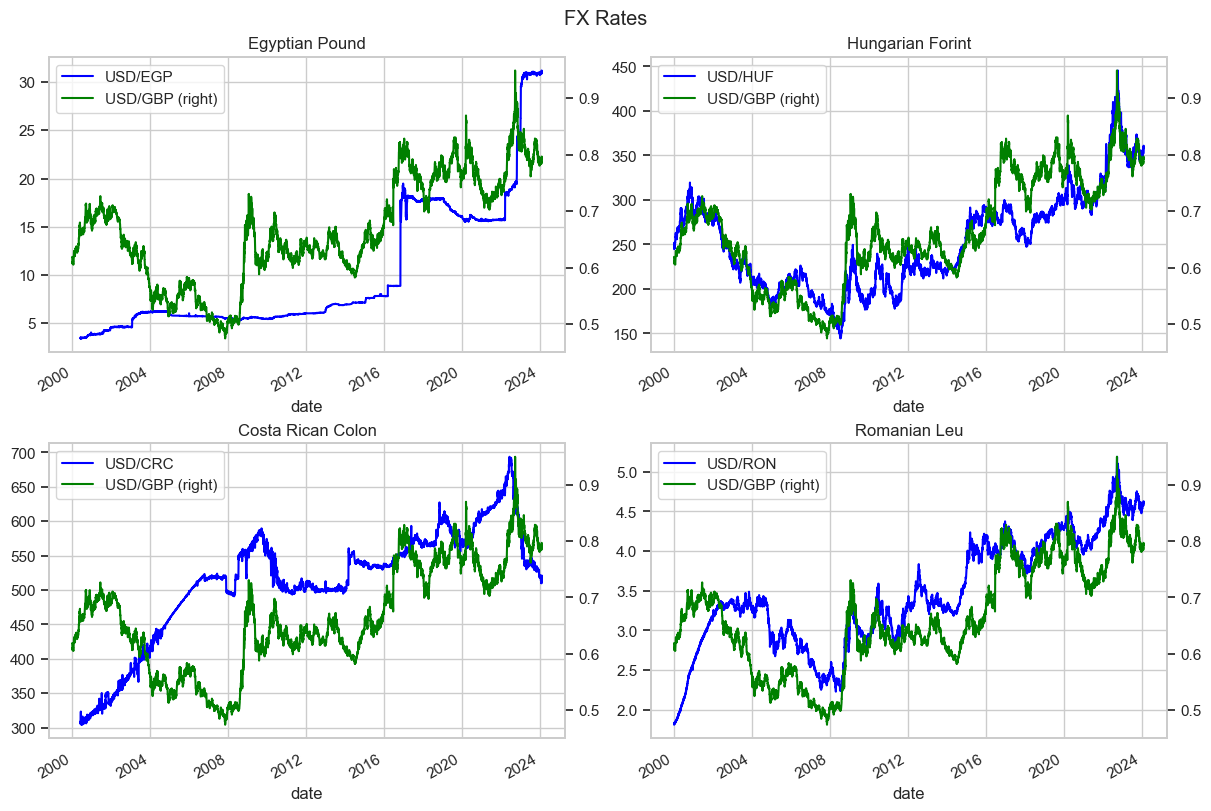

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=2, constrained_layout=True, figsize=(12, 8))
fig.suptitle("FX Rates")

fx_EGP.plot(ax=axes[0, 0], title="Egyptian Pound")
fx_GBP.plot(ax=axes[0, 0], secondary_y=True)

fx_HUF.plot(ax=axes[0, 1], title="Hungarian Forint")
fx_GBP.plot(ax=axes[0, 1], secondary_y=True)

# Plot Costa Rican Colon and overlay GBP
fx_CRC.plot(ax=axes[1, 0], title="Costa Rican Colon")
fx_GBP.plot(ax=axes[1, 0], secondary_y=True)

fx_RON.plot(ax=axes[1, 1], title="Romanian Leu")
fx_GBP.plot(ax=axes[1, 1], secondary_y=True)

plt.show()

We tried to visualize the different lending currencies against our borrowing currency which is the pound here. They all look very correlated except for the Costa Rican Colon which shows an inverse correlation with the pound at the beginning of the period. This is clearly what we can observe on the heatmap below. The Costa Rican Colon is the only currency that shows very little correlation with the other ones.

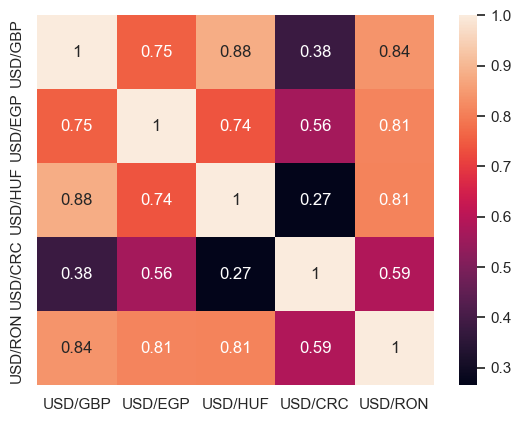

In [7]:
sns.heatmap(currency_fx.corr(), annot=True);

#### 2.1.2. UK Overnight Index Swaps (OIS) - Borrowing Leg

The second thing we are going to obtain now is the shortest available rates for UK overnight index swaps (OIS) — series IUDSOIA. At the same time, we are also getting the 5Y swap rate which is going to be used to compare with the 5Y swap rates of the lending currencies.

The data for the 10Y swap rate is not available before 2021, so we are going to use the 5Y swap rate instead for the period before 2021.

In [8]:
ois_data = pd.read_excel('./Homework_5/OIS daily data.xlsx')
ois_data['Date'] = pd.to_datetime(ois_data['Date'])
ois_data = ois_data.set_index('Date')
ois_data.head()

IUDSOIA       0.5         1         5        10
Date                                                        
2009-01-01       NaN       NaN       NaN       NaN       NaN
2009-01-02  1.279724  0.915110  0.900074  2.449408  2.449408
2009-01-05  1.204601  0.893225  0.910197  2.517381  2.517381
2009-01-06  1.173760  0.908151  0.959605  2.543254  2.543254
2009-01-07  1.113437  0.858014  0.888158  2.470700  2.470700

In [9]:
# Shortest available rates for UK overnight index swaps (OIS) — series IUDSOIA

ois = ois_data[['IUDSOIA']]

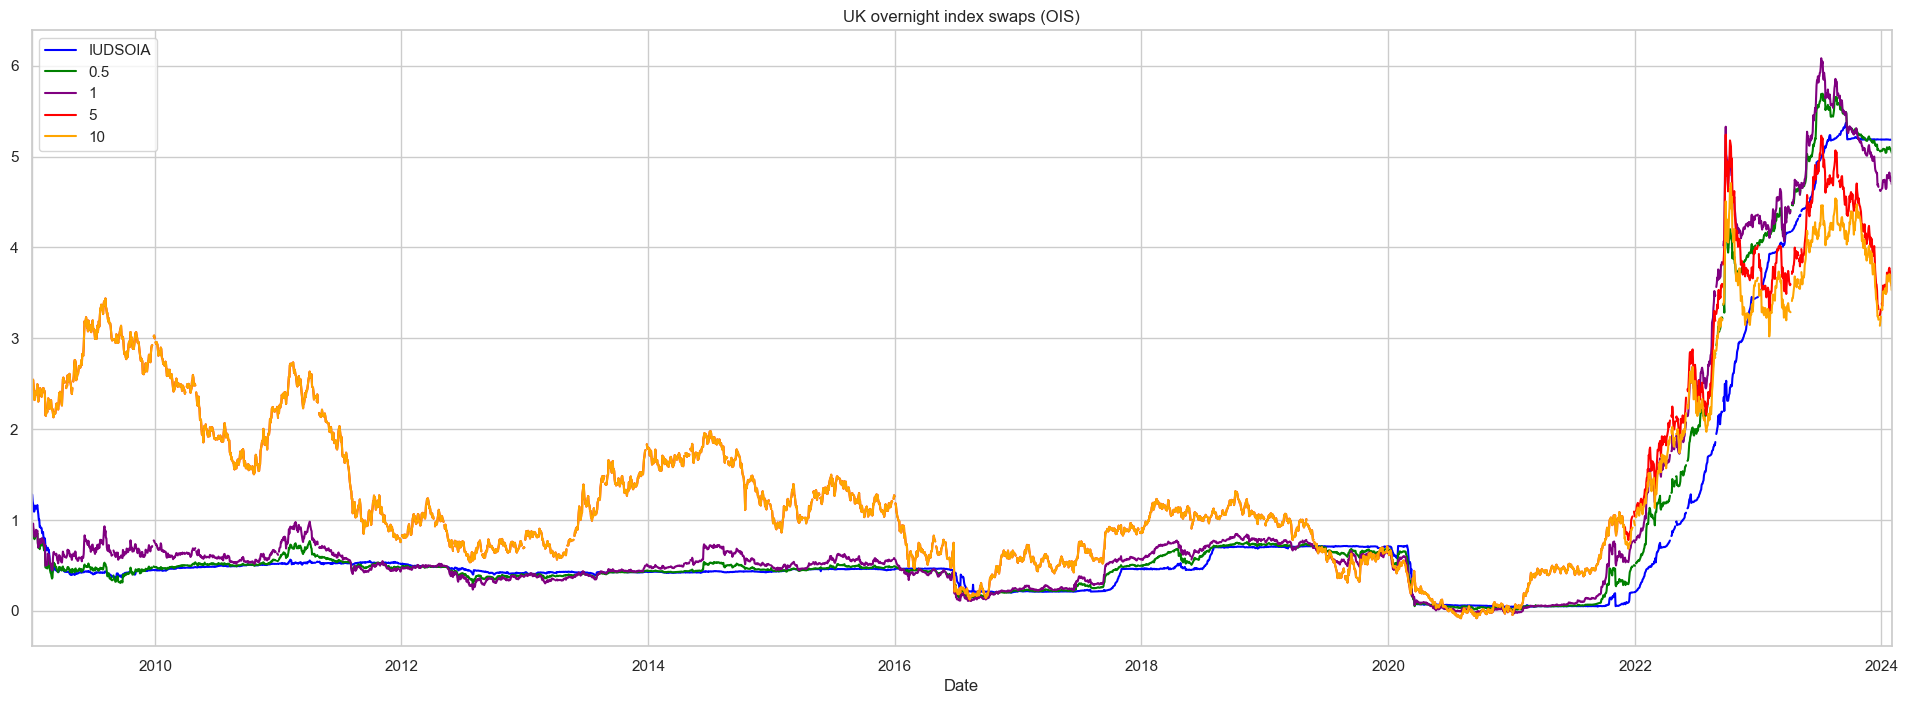

In [10]:
ois_data.plot(figsize=(24, 8))
plt.title('UK overnight index swaps (OIS)')
plt.show()

#### 2.1.3. Swap Yield Curves

Finally, we get the swap yield curves associated to the countries for which we retrieved the FX rates.

In [11]:
inferred_yield_curves = pd.read_table('./Homework_5/InferredYieldCurves_2024.tab')
inferred_yield_curves['date'] = pd.to_datetime(inferred_yield_curves['date'])
inferred_yield_curves.head()

Unnamed: 0       shortname tenor       date     yield
0        3401  Arab Rep Egypt   10Y 2010-01-04  0.075885
1        3402  Arab Rep Egypt   10Y 2010-01-05  0.074642
2        3403  Arab Rep Egypt   10Y 2010-01-06  0.074318
3        3404  Arab Rep Egypt   10Y 2010-01-07  0.073642
4        3405  Arab Rep Egypt   10Y 2010-01-08  0.073024

In [12]:
def get_yield_curve(data, shortname):
    yc = data[data['shortname'] == shortname]
    yc = yc.drop(columns=['Unnamed: 0', 'shortname'])
    yc = yc.rename(columns={'yield': 'yield ' + shortname})
    yc.loc[:, 'tenor'] = yc['tenor'].apply(lambda x: x.replace('Y', ''))
    yc.loc[:, 'tenor'] = yc['tenor'].apply(lambda x: x.replace('6M', '0.5'))
    yc.loc[:, 'tenor'] = yc['tenor'].astype(float)
    yc = yc.pivot_table(index='tenor', columns='date', values='yield ' + shortname)
    yc = yc.T.interpolate(axis = 0, method = 'index').T
    return yc

In [13]:
yield_curves_EGP = get_yield_curve(inferred_yield_curves, 'Arab Rep Egypt')
yield_curves_HUF = get_yield_curve(inferred_yield_curves, 'Hungary')
yield_curves_CRC = get_yield_curve(inferred_yield_curves, 'Rep Costa Rica')
yield_curves_RON = get_yield_curve(inferred_yield_curves, 'Romania')

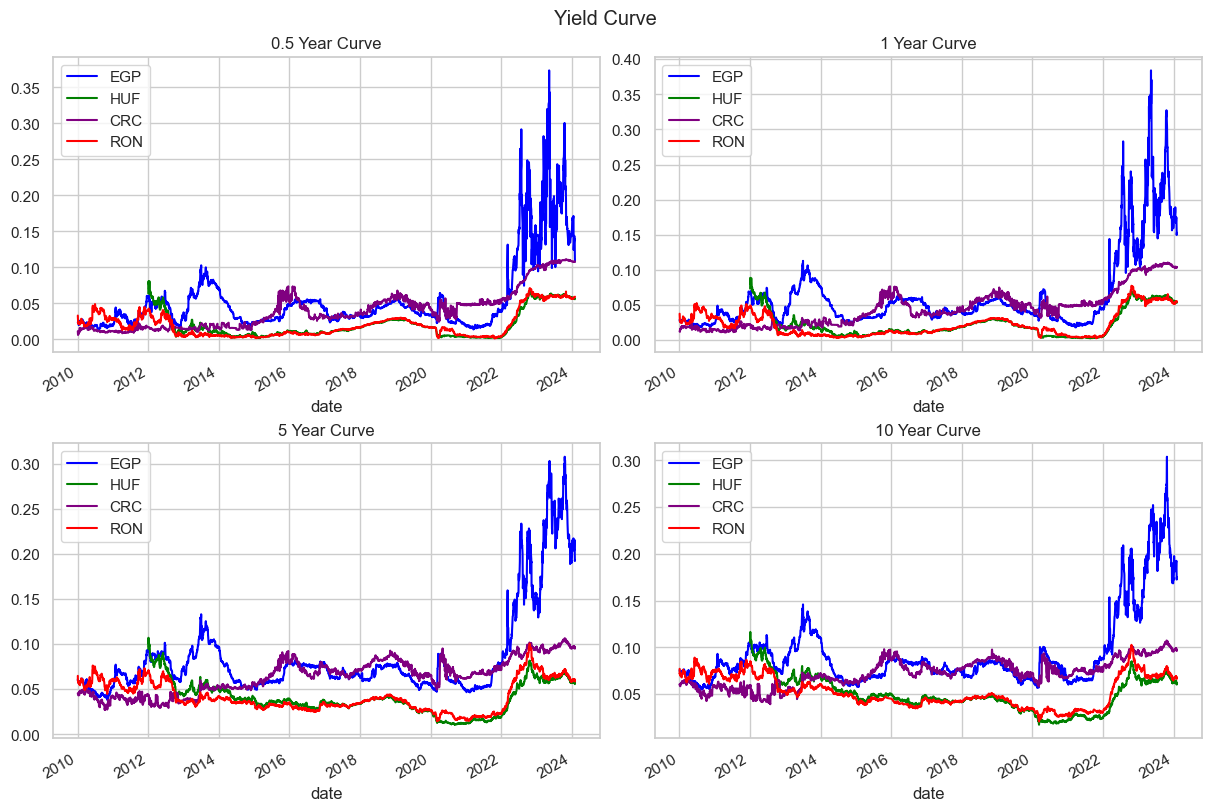

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=2, constrained_layout=True)

yield_curves_EGP.T[0.5].plot(ax=axes[0, 0], title="0.5 Year Curve", figsize=(12, 8), label='EGP')
yield_curves_HUF.T[0.5].plot(ax=axes[0, 0], title="0.5 Year Curve", figsize=(12, 8), label='HUF')
yield_curves_CRC.T[0.5].plot(ax=axes[0, 0], title="0.5 Year Curve", figsize=(12, 8), label='CRC')
yield_curves_RON.T[0.5].plot(ax=axes[0, 0], title="0.5 Year Curve", figsize=(12, 8), label='RON')

yield_curves_EGP.T[1.0].plot(ax=axes[0, 1], title="1 Year Curve", figsize=(12, 8), label='EGP')
yield_curves_HUF.T[1.0].plot(ax=axes[0, 1], title="1 Year Curve", figsize=(12, 8), label='HUF')
yield_curves_CRC.T[1.0].plot(ax=axes[0, 1], title="1 Year Curve", figsize=(12, 8), label='CRC')
yield_curves_RON.T[1.0].plot(ax=axes[0, 1], title="1 Year Curve", figsize=(12, 8), label='RON')

yield_curves_EGP.T[5.0].plot(ax=axes[1, 0], title="5 Year Curve", figsize=(12, 8), label='EGP')
yield_curves_HUF.T[5.0].plot(ax=axes[1, 0], title="5 Year Curve", figsize=(12, 8), label='HUF')
yield_curves_CRC.T[5.0].plot(ax=axes[1, 0], title="5 Year Curve", figsize=(12, 8), label='CRC')
yield_curves_RON.T[5.0].plot(ax=axes[1, 0], title="5 Year Curve", figsize=(12, 8), label='RON')

yield_curves_EGP.T[10.0].plot(ax=axes[1, 1], title="10 Year Curve", figsize=(12, 8), label='EGP')
yield_curves_HUF.T[10.0].plot(ax=axes[1, 1], title="10 Year Curve", figsize=(12, 8), label='HUF')
yield_curves_CRC.T[10.0].plot(ax=axes[1, 1], title="10 Year Curve", figsize=(12, 8), label='CRC')
yield_curves_RON.T[10.0].plot(ax=axes[1, 1], title="10 Year Curve", figsize=(12, 8), label='RON')

for ax in axes.flatten():
    ax.legend()

fig.suptitle("Yield Curve")
plt.show()

#### 2.2. Data Transformation

For the purpose of our strategy, we are going to price bonds. Therefore, we need to extract from the swap yield curves the zero-coupon bond curve.

In [15]:
def compute_zcb_curve(spot_rates_curve):
    zcb_rates = spot_rates_curve.copy()
    for curve in spot_rates_curve.columns:
        spot = spot_rates_curve[curve]
        for tenor, spot_rate in spot.items():
            if tenor > 0.001:
                times = np.arange(tenor - 0.5, 0, step=-0.5)[::-1]
                coupon_half_yr = 0.5 * spot_rate
                z = np.interp(times, zcb_rates[curve].index.values, zcb_rates[curve].values)  # Linear interpolation
                preceding_coupons_val = (coupon_half_yr * np.exp(-z * times)).sum()
                zcb_rates[curve][tenor] = -np.log((1 - preceding_coupons_val) / (1 + coupon_half_yr)) / tenor
    return zcb_rates.T

In [16]:
zero_curve_EGP = compute_zcb_curve(yield_curves_EGP)
zero_curve_HUF = compute_zcb_curve(yield_curves_HUF)
zero_curve_CRC = compute_zcb_curve(yield_curves_CRC)
zero_curve_RON = compute_zcb_curve(yield_curves_RON)

### 3. Trading Strategy Implementation

Now that all the data we need is clean and ready to use, we can start implementing our carry trade strategy. This strategy can be decomposed into two legs: the borrowing leg and the lending leg.

In the borrowing (funding) currency, we assume a rate of OIS plus 50bps, paid on 4/5 the notional amount (5x leverage). Our interest payment will be one week at this funding rate, multiplied by our borrowed amount. Since we will be working with a notional of US$10MM, we borrow the funding-currency equivalent of 8MM USD at the starting FX rate. When closing our position, we must return that same amount of home currency at the new FX rate, plus 1 week of interest on it (also in home currency) at the entry rate.

In the lending currency, we assume the schedule has a coupon every quarter at the 5Y swap rate. In the weeks in which the 5Y swap rate of the lending currency is less than 50bps higher than the 5Y swap rate in the funding currency, we will assume to have no position.

At the end of each week, we sell out our position before opening a new one. Therefore, we need to tally accrued interest at the borrow rate, and then compute mark-to-market for the swap exit. All the flows will be converted to USD at the current FX rate for the different currencies in order to follow the performance of our strategy.

#### 3.1. Preliminary Work

Before going further, let's make an inventory of the data we have for the different currencies and the parameters that are going to be modified in the strategy.

In [17]:
# Create a dictionary for each currency

GBP = {'fx': fx_GBP, 'yield': ois_data, 'ois': ois}

EGP = {'fx': fx_EGP, 'yield': yield_curves_EGP, 'zero': zero_curve_EGP}
HUF = {'fx': fx_HUF, 'yield': yield_curves_HUF, 'zero': zero_curve_HUF}
CRC = {'fx': fx_CRC, 'yield': yield_curves_CRC, 'zero': zero_curve_CRC}
RON = {'fx': fx_RON, 'yield': yield_curves_RON, 'zero': zero_curve_RON}

As we have seen in our rates dataframes, we have different maturities. We are going to work by default with the 5Y, but we can also consider the 0.5Y, 1Y and 10Y maturities that are available in our data. This is going the exploratory part of our strategy optimization.

In [18]:
maturities = [0.5, 1.0, 5.0, 10.0]

#### 3.2. Trading Logic

The provided code defines a class named `CarryTrade` that encapsulates the logic for simulating a carry trade strategy. Carry trade involves borrowing in a currency with a low-interest rate (funding currency) and investing in a currency with a higher interest rate (target currency) to profit from the interest rate differential. This strategy is often used in the forex markets.

When an instance of the `CarryTrade` class is created, the `__init__` method initializes the object with various parameters related to the borrowing and lending legs of the trade, including the interest rates, foreign exchange (FX) rates, and notional amounts. The data for both borrowing and lending legs are interpolated and resampled to weekly frequencies to align the time series, ensuring that the analysis is conducted on a consistent time basis, specifically on Wednesdays here.

The class contains methods to determine the start and end dates for the trade by finding the common date range across all provided data series. It filters the data to this common date range to ensure consistency.

The `detect_signals` method calculates where the carry trade is viable by comparing the difference between the lending swap rates and the borrowing rates. A trade signal is generated when this difference is more than 50 basis points (bps), suggesting conditions for a potential carry trade.

The `bond_price_fun` static method is a utility function for calculating the price of a bond given a zero-coupon bond (ZCB) curve, a coupon rate, and the bond's tenor. It uses linear interpolation to find the appropriate interest rates at different times until maturity and calculates the present value of future cash flows to determine the bond price.

To simulate the carry trade, the class implements methods to calculate the cash flows for both borrowing and lending legs, incorporating FX rate changes, interest payments, and bond price fluctuations. The `calculate_borrow_leg` method simulates borrowing in the funding currency, including interest costs, while the `calculate_lending_leg` method simulates investing in the target currency by buying bonds and later selling them.

Finally, the `calculate_flows_and_pnl` method combines the results from both legs to calculate the profit and loss (PnL) from the trade, including cumulative PnL and strategy returns, in the local currency of our strategy which is USD. The `execute_trade` method orchestrates the execution of the strategy by filtering dates, detecting signals, pricing bonds, calculating borrowing and lending legs, and ultimately, the trade's overall financial impact.

This class provides a comprehensive framework for evaluating the viability and performance of carry trade strategies, factoring in both interest rate differentials and FX rate movements. It allows for a detailed analysis of the potential returns from engaging in such trades over specified periods.

In [19]:
class CarryTrade:
    def __init__(self, borrow_rate, borrow_fx, borrowing_swap_rates, lending_coupon_rate, lending_swap_rates, lending_fx, zero_curve, notional=10e6, start_date=None, end_date=None):

        # Borrowing leg
        self.borrowing_swap_rates = borrowing_swap_rates.interpolate(axis = 0, method = 'index').resample('W-WED').last().ffill() / 100
        self.borrow_rate = borrow_rate.interpolate(axis = 0, method = 'index').resample('W-WED').last().ffill() / 100
        self.borrow_fx = borrow_fx.resample('W-WED').last().ffill()

        self.borrow_flow = None

        # Lending leg
        self.lending_swap_rates = lending_swap_rates.interpolate(axis = 0, method = 'index').resample('W-WED').last().ffill()
        self.zero_curve = zero_curve.interpolate(axis = 0, method = 'index').resample('W-WED').last().ffill()
        self.lending_coupon_rate = lending_coupon_rate.interpolate(axis = 0, method = 'index').resample('W-WED').last().ffill()
        self.lending_fx = lending_fx.resample('W-WED').last().ffill()

        self.bond_price = None
        self.lending_flow = None

        # Strategy parameters
        self.notional = notional
        self.borrow_amount = self.notional * 4 / 5
        self.investment_amount = self.notional - self.borrow_amount

        # Dates
        self.start_date = start_date if start_date else self.get_start_date()
        self.end_date = end_date if end_date else self.get_end_date()

        # Execution
        self.signals = None
        self.report = None

    def get_start_date(self):
        return max([df.index[0] for df in [self.borrow_rate, self.borrow_fx, self.borrowing_swap_rates, self.lending_swap_rates, self.zero_curve, self.lending_coupon_rate, self.lending_fx]])

    def get_end_date(self):
        return min([df.index[-1] for df in [self.borrow_rate, self.borrow_fx, self.borrowing_swap_rates, self.lending_swap_rates, self.zero_curve, self.lending_coupon_rate, self.lending_fx]])

    def filter_dates(self):
        self.borrow_rate = self.borrow_rate.loc[self.start_date:self.end_date]
        self.borrow_fx = self.borrow_fx.loc[self.start_date:self.end_date]
        self.borrowing_swap_rates = self.borrowing_swap_rates.loc[self.start_date:self.end_date]
        self.lending_swap_rates = self.lending_swap_rates.loc[self.start_date:self.end_date]
        self.zero_curve = self.zero_curve.loc[self.start_date:self.end_date]
        self.lending_coupon_rate = self.lending_coupon_rate.loc[self.start_date:self.end_date]
        self.lending_fx = self.lending_fx.loc[self.start_date:self.end_date]

    def detect_signals(self):
        positions = self.lending_swap_rates.values - self.borrowing_swap_rates.values > 50 / 10000  # 50bp
        self.signals = pd.DataFrame(positions, index=self.borrowing_swap_rates.index, columns=['Signal'])
    
    @staticmethod
    def bond_price_fun(zcb, coupon_rate, tenor):
        times = np.arange(tenor, 0, step=-0.5)[::-1]
        if times.shape[0] == 0:
            p = 1.0
        else:
            r = np.interp(times, zcb.index.values, zcb.values)  # Linear interpolation
            p = np.exp(-tenor * r[-1]) + 0.5 * coupon_rate * np.exp(-r * times).sum()
        return p

    def price_bond(self):
        bond_prices = pd.DataFrame(np.nan, index=self.lending_swap_rates.index, columns=['Bond Price', 'Bond Price 1W'])

        for date in self.lending_swap_rates.index:
            # The day we buy the bond it will be priced to par so its px/value will be 1 unit of risky currency
            bond_prices.loc[date, 'Bond Price'] = 1.
            # We reprice our bond the following week with the new zero curve but the initial coupon rate of the bond, and with 1 week less to maturity
            bond_prices.loc[date, 'Bond Price 1W'] = self.bond_price_fun(self.zero_curve.shift(-1).T[date], self.lending_coupon_rate.loc[date].values, self.lending_coupon_rate.columns[0] - 1 / 52)[0]

        self.bond_price = bond_prices

    def calculate_borrow_leg(self):
        borrow_leg_df = pd.DataFrame(index=self.signals.index, columns=['Interest Rate', 'Borrowed USD', 'Borrowed GBP', 'Interest GBP', 'Borrowed USD End', 'Interest USD'])

        for day in self.signals.index:
            if self.signals.loc[day, 'Signal']:
                borrow_leg_df.loc[day, 'Interest Rate'] = self.borrow_rate.loc[day].values + 50 / 10000

                borrow_leg_df.loc[day, 'Borrowed USD'] = self.borrow_amount
                borrow_leg_df.loc[day, 'Borrowed GBP'] = self.borrow_amount * self.borrow_fx.loc[day].values

                # The interests are calculated on the borrowed amount for the week
                borrow_leg_df.loc[day, 'Interest GBP'] = borrow_leg_df.loc[day, 'Borrowed GBP'] * borrow_leg_df.loc[day, 'Interest Rate'] / 52

                # We need to calculate the amount of USD we need to return at the end of the week, using the new FX rate
                next_week_fx = self.borrow_fx.shift(-1).loc[day].values
                borrow_leg_df.loc[day, 'Borrowed USD End'] = borrow_leg_df.loc[day, 'Borrowed GBP'] / next_week_fx

                borrow_leg_df.loc[day, 'Interest USD'] = borrow_leg_df.loc[day, 'Interest GBP'] / next_week_fx

        self.borrow_flow = borrow_leg_df

    def calculate_lending_leg(self):
        lending_flow_df = pd.DataFrame(index=self.signals.index, columns=['Lending USD', 'Converted USD', 'Bonds Bought', 'Sell Amount Lending Currency', 'Reconverted USD'])

        for day in self.signals.index:
            if self.signals.loc[day, 'Signal']:
                lending_flow_df.loc[day, 'Lending USD'] = self.notional
                
                lending_flow_df.loc[day, 'Converted USD'] = self.notional * self.lending_fx.loc[day].values

                lending_flow_df.loc[day, 'Bonds Bought'] = lending_flow_df.loc[day, 'Converted USD'] / self.bond_price.loc[day, 'Bond Price']

                lending_flow_df.loc[day, 'Sell Amount Lending Currency'] = lending_flow_df.loc[day, 'Bonds Bought'] * self.bond_price.loc[day, 'Bond Price 1W']
                
                next_week_fx = self.lending_fx.shift(-1).loc[day].values
                lending_flow_df.loc[day, 'Reconverted USD'] = lending_flow_df.loc[day, 'Sell Amount Lending Currency'] / next_week_fx

        self.lending_flow = lending_flow_df

    def calculate_flows_and_pnl(self):
        pnl_df = pd.DataFrame(index=self.signals.index, columns=['PnL Borrow Leg', 'Cumulative PnL Borrow Leg', 'Cumulative Interest', 'PnL Lending Leg', 'Cumulative PnL Lending Leg', 'Total PnL', 'Cumulative PnL', 'Strategy Return'])

        pnl_df['PnL Borrow Leg'] = self.borrow_flow['Borrowed USD'] - (self.borrow_flow['Borrowed USD End'] + self.borrow_flow['Interest USD'])

        pnl_df['PnL Lending Leg'] = self.lending_flow['Reconverted USD'] - self.lending_flow['Lending USD']

        pnl_df['Total PnL'] = pnl_df['PnL Borrow Leg'] + pnl_df['PnL Lending Leg']

        pnl_df.fillna(0, inplace=True)

        pnl_df['Cumulative PnL'] = pnl_df['Total PnL'].cumsum()
        pnl_df['Cumulative PnL'].ffill(inplace=True)
        pnl_df['Cumulative PnL Borrow Leg'] = pnl_df['PnL Borrow Leg'].cumsum()
        pnl_df['Cumulative PnL Borrow Leg'].ffill(inplace=True)
        pnl_df['Cumulative PnL Lending Leg'] = pnl_df['PnL Lending Leg'].cumsum()
        pnl_df['Cumulative PnL Lending Leg'].ffill(inplace=True)
        pnl_df['Cumulative Interest'] = - self.borrow_flow['Interest USD'].cumsum()
        pnl_df['Cumulative Interest'].ffill(inplace=True)

        pnl_df['Strategy Return'] = pnl_df['Total PnL'] / self.investment_amount

        self.report = pnl_df.shift(1).fillna(0)  # We shift to consider the PnL at the time when we close the position

    def execute_trade(self):
        self.filter_dates()
        self.detect_signals()
        self.price_bond()
        self.calculate_borrow_leg()
        self.calculate_lending_leg()
        self.calculate_flows_and_pnl()

#### 3.3. Strategy Execution

Let's now execute the strategy for the Costa Rican Colon to see how it works. We give as inputs:
* the OIS rates at which we are going to borrow (1m swap rate) and that is algo going to be the reference for our signal (5Y swap rate)
* the FX rates for the borrowing and lending currencies
* the swap rates for the lending leg that we will use as reference for our signal also, and to get the coupons for our bonds
* the zero-coupon bond curve for the lending currency to price our bonds

In [20]:
carry_trade_ex = CarryTrade(
    borrow_rate=ois,
    borrow_fx=fx_GBP,
    borrowing_swap_rates=ois_data[[5.0]],
    lending_coupon_rate=yield_curves_CRC.T[[5.0]],
    lending_swap_rates=yield_curves_CRC.T[[5.0]],
    lending_fx=fx_CRC,
    zero_curve=zero_curve_CRC,
    notional=10e6)

carry_trade_ex.execute_trade()

In [21]:
def plot_carry_trade_performance(carry_trade, currency):
    sns.set(style="whitegrid")
    custom_palette = ['green', 'blue', 'purple', 'red', 'orange']
    sns.set_palette(custom_palette)

    display(carry_trade.report.tail())

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 12), gridspec_kw={'height_ratios': [2, 2]})
    fig.suptitle('Carry Trade Performance Metrics for ' + currency, fontsize=16)

    carry_trade.report[['Cumulative PnL Borrow Leg', 'Cumulative PnL Lending Leg', 'Cumulative PnL', 'Cumulative Interest']].plot(ax=axes[0, 0])
    axes[0, 0].set_title('PnL Overview')
    axes[0, 0].set_ylabel('Profit and Loss')
    axes[0, 0].set_xlabel('Date')

    carry_trade.report['Strategy Return'].plot(ax=axes[0, 1], label='Strategy Return')
    axes[0, 1].set_title('Strategy Returns')
    axes[0, 1].set_ylabel('Return')
    axes[0, 1].set_xlabel('Date')

    carry_trade.borrow_fx.plot(ax=axes[1, 0], label='Borrow FX Rate')
    carry_trade.lending_fx.plot(ax=axes[1, 0], label='Lending FX Rate', secondary_y=True)
    axes[1, 0].set_title('FX Rates')
    axes[1, 0].set_ylabel('FX Rate')
    axes[1, 0].set_xlabel('Date')

    borrow_rate_plot = carry_trade.borrow_rate.copy()
    borrow_rate_plot.columns = 'Borrowing Rate - ' + carry_trade.borrow_rate.columns.astype(str)
    borrow_rate_plot.plot(ax=axes[1, 1], label='Borrowing Rate')

    lending_rate_plot = carry_trade.lending_swap_rates.copy()
    lending_rate_plot.columns = 'Lending Rate - ' + carry_trade.lending_swap_rates.columns.astype(str) + 'Y'
    lending_rate_plot.columns.name = None
    lending_rate_plot.plot(ax=axes[1, 1], label='Lending Rate', secondary_y=True)
    
    borrow_rate_Y = carry_trade.borrowing_swap_rates.copy()
    borrow_rate_Y.columns = ['Borrowing Rate - ' + str(borrow_rate_Y.columns[0]) + 'Y']
    borrow_rate_Y.plot(ax=axes[1, 1], label='Borrowing Rate Y', secondary_y=True)

    axes[1, 1].set_title('Borrowing Rate')
    axes[1, 1].set_ylabel('Rate')
    axes[1, 1].set_xlabel('Date')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    cumulative_pnl = carry_trade.report['Cumulative PnL'].iloc[-1]
    strategy_return = cumulative_pnl / carry_trade.investment_amount
    print(f'The cumulative profit and loss is ${cumulative_pnl:.2f}.')
    print(f'The return on capital for the last period is {strategy_return:.2%}.')

PnL Borrow Leg  Cumulative PnL Borrow Leg  Cumulative Interest  \
Date                                                                         
2024-01-03    53598.693589              -38961.809131        -1.454502e+06   
2024-01-10   -51447.224481              -90409.033613        -1.463299e+06   
2024-01-17    48627.339081              -41781.694532        -1.471986e+06   
2024-01-24   -68129.914956             -109911.609488        -1.480802e+06   
2024-01-31     6827.690188             -103083.919300        -1.489532e+06   

            PnL Lending Leg  Cumulative PnL Lending Leg      Total PnL  \
Date                                                                     
2024-01-03     10368.748533                1.092870e+07   63967.442121   
2024-01-10     14163.215917                1.094286e+07  -37284.008564   
2024-01-17      1943.794106                1.094481e+07   50571.133187   
2024-01-24    138185.566877                1.108299e+07   70055.651921   
2024-01-31    105512.716575                1.118851e+07  112340.406763   

            Cumulative PnL  Strategy Return  
Date                                         
2024-01-03    1.088974e+07         0.031984  
2024-01-10    1.085246e+07        -0.018642  
2024-01-17    1.090303e+07         0.025286  
2024-01-24    1.097308e+07         0.035028  
2024-01-31    1.108542e+07         0.056170

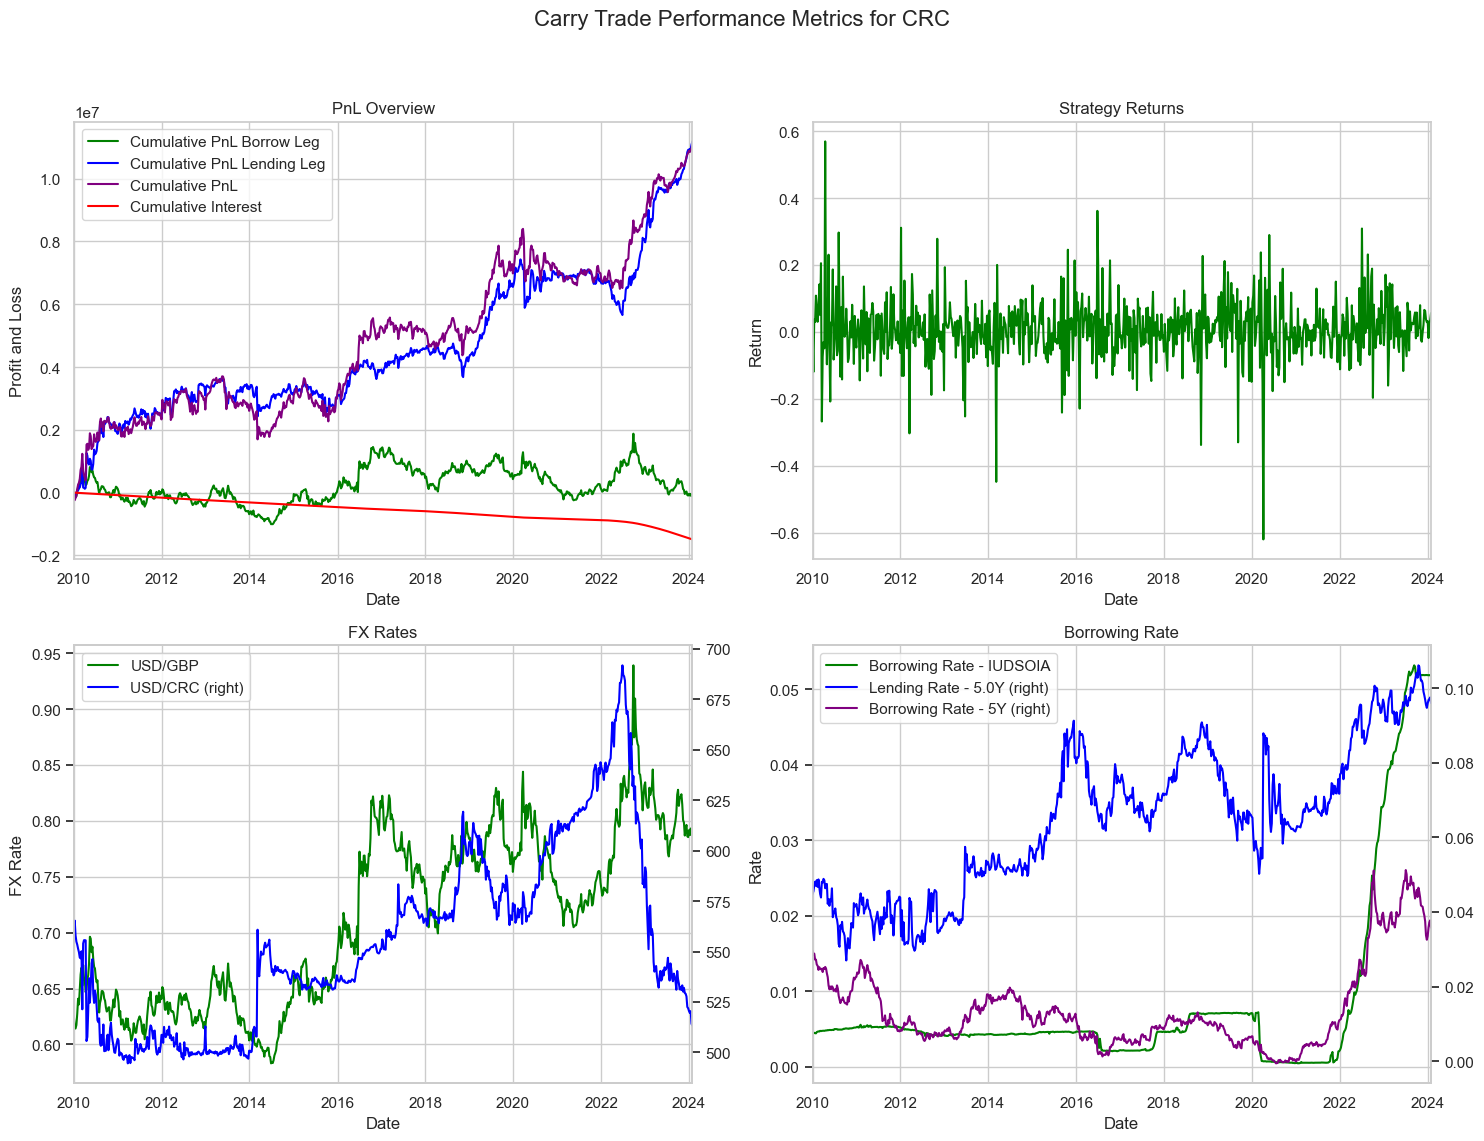

The cumulative profit and loss is $11085422.47.
The return on capital for the last period is 554.27%.


In [22]:
plot_carry_trade_performance(carry_trade_ex, 'CRC')

Let's take some time now to explain how to read the different plots, that will later help us to analyze the performance of our strategy.

The top right plot shows the profit and loss (PnL) for the borrowing and lending legs, as well as the cumulative PnL and the cumulative interest. The borrowing leg PnL is the difference between the borrowed amount and the amount to be returned at the end of the week, minus the interest paid. The lending leg PnL is the difference between the re-sell amount of our bonds converted back to USD and the initial amount lent. The cumulative PnL is the sum of the PnL for both legs, while the cumulative interest is the sum of the interest paid on the borrowed amount. Here we can clearly see that the cumulative interest is negative, which is normal as we are the ones borrowing money. The cumulative PnL of the lending leg is oscillating due to foreign exchange rate fluctuations when changing USD to GBP back and forth, but we also pay interest on the borrowed amount, which makes it negative. It appears that the foreign exchange rate is in our favor as the borrowing leg manages to stay positive or around 0 while paying interests. The two foreign exchange rates are also plotted in the plot below, and we can see that the lending currency. The cumulative PnL of our strategy is positive and follows closely the lending leg cumulative PnL, which makes sense because of the reasons we just mentioned.

On the top left plot, we have the strategy return, which is the PnL divided by the investment amount of US$2M for us. It is the most important metric to follow as it gives us the return on our capital. We will use those returns to compute the different performance metrics of our strategy later on.

Finally, on the left bottom plot, we have the borrowing and lending rates.

### 4. Analysis

Now that we have implemented our strategy, we are going to run it for our different currencies available to analyse the performance of each separately. Then we will compare those performances and to to understand the dynamics between the different currencies.

#### 4.1. Strategy on Different Currencies

Let's first run our strategy on the different currencies we have available and try to change the maturities of the swap rates to see how it impacts the performances. We will study each currency separately in this section and compute for the best maturity, the detailed performance metrics of our strategy.

In [23]:
def run_carry_trade(maturities, GBP, currency , notional=10e6):
    carry_trades = {}
    for maturity in maturities:
        carry_trade = CarryTrade(
            borrow_rate=GBP['ois'],
            borrow_fx=GBP['fx'],
            borrowing_swap_rates=GBP['yield'][[maturity]],
            lending_coupon_rate=currency['yield'].T[[maturity]],
            lending_swap_rates=currency['yield'].T[[maturity]],
            lending_fx=currency['fx'],
            zero_curve=currency['zero'],
            notional=notional)
        carry_trade.execute_trade()
        carry_trades[maturity] = carry_trade
    return carry_trades

In [24]:
carry_trades_HUF = run_carry_trade(maturities, GBP, HUF)
carry_trades_EGP = run_carry_trade(maturities, GBP, EGP)
carry_trades_CRC = run_carry_trade(maturities, GBP, CRC)
carry_trades_RON = run_carry_trade(maturities, GBP, RON)

In [25]:
def plot_and_summarize_carry_trades(trades_dict, currency):
    sns.set(style="whitegrid")
    custom_palette = ['green', 'blue', 'purple', 'orange', 'red']
    sns.set_palette(custom_palette)

    df_cumulative_pnl = pd.DataFrame()
    df_cumulative_pnl_lending = pd.DataFrame()
    df_cumulative_pnl_borrowing = pd.DataFrame()
    df_lending_swap_rates = pd.DataFrame()
    df_returns = pd.DataFrame()

    for maturity, trade in trades_dict.items():
        df_cumulative_pnl[str(maturity) + 'Y'] = trade.report['Cumulative PnL']
        df_cumulative_pnl_lending[str(maturity) + 'Y'] = trade.report['Cumulative PnL Lending Leg']
        df_cumulative_pnl_borrowing[str(maturity) + 'Y'] = trade.report['Cumulative PnL Borrow Leg']
        df_lending_swap_rates[str(maturity) + 'Y'] = trade.lending_swap_rates.mean(axis=1)
        df_returns[currency + ' - ' + str(maturity) + 'Y'] = trade.report['Strategy Return']   

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Carry Trade Performance Metrics for ' + currency, fontsize=16)
    
    df_cumulative_pnl.plot(ax=axes[0, 0], title='Cumulative PnL')
    axes[0, 0].set_ylabel('PnL')
    axes[0, 0].set_xlabel('Date')

    df_lending_swap_rates.plot(ax=axes[0, 1], title='Lending Swap Rates')
    axes[0, 1].set_ylabel('Rate')
    axes[0, 1].set_xlabel('Date')

    df_cumulative_pnl_borrowing.plot(ax=axes[1, 0], title='Cumulative PnL Borrowing Leg')
    axes[1, 0].set_ylabel('PnL')
    axes[1, 0].set_xlabel('Date')

    df_cumulative_pnl_lending.plot(ax=axes[1, 1], title='Cumulative PnL Lending Leg')
    axes[1, 1].set_ylabel('PnL')
    axes[1, 1].set_xlabel('Date')

    plt.tight_layout()
    plt.show()

    summary_df = pd.DataFrame({
        'Total Cumulative PnL - ' + str(currency): {maturity: trade.report['Cumulative PnL'].iloc[-1] for maturity, trade in trades_dict.items()}
    })

    display(summary_df.T.applymap(lambda x: "${:,.2f}M".format(x/1000000)))
    
    return summary_df, df_returns

##### 4.1.1. Hungarian Forint (HUF)

Let's start with the Hungarian Forint. Since 2012, the Hungarian Forint (HUF) has navigated through a mix of domestic and international influences, including aggressive monetary policies by the National Bank of Hungary and various economic reforms aimed at stimulating growth and reducing public debt. These measures, alongside efforts to maintain inflation within target ranges, have directly impacted the forint's value against major currencies. The currency has also been sensitive to global economic trends and Hungary's complex relationship with the European Union, which have contributed to periods of volatility. Overall, the HUF's performance reflects Hungary's economic policy decisions, its response to global economic conditions, and the interplay between domestic and EU-related factors.

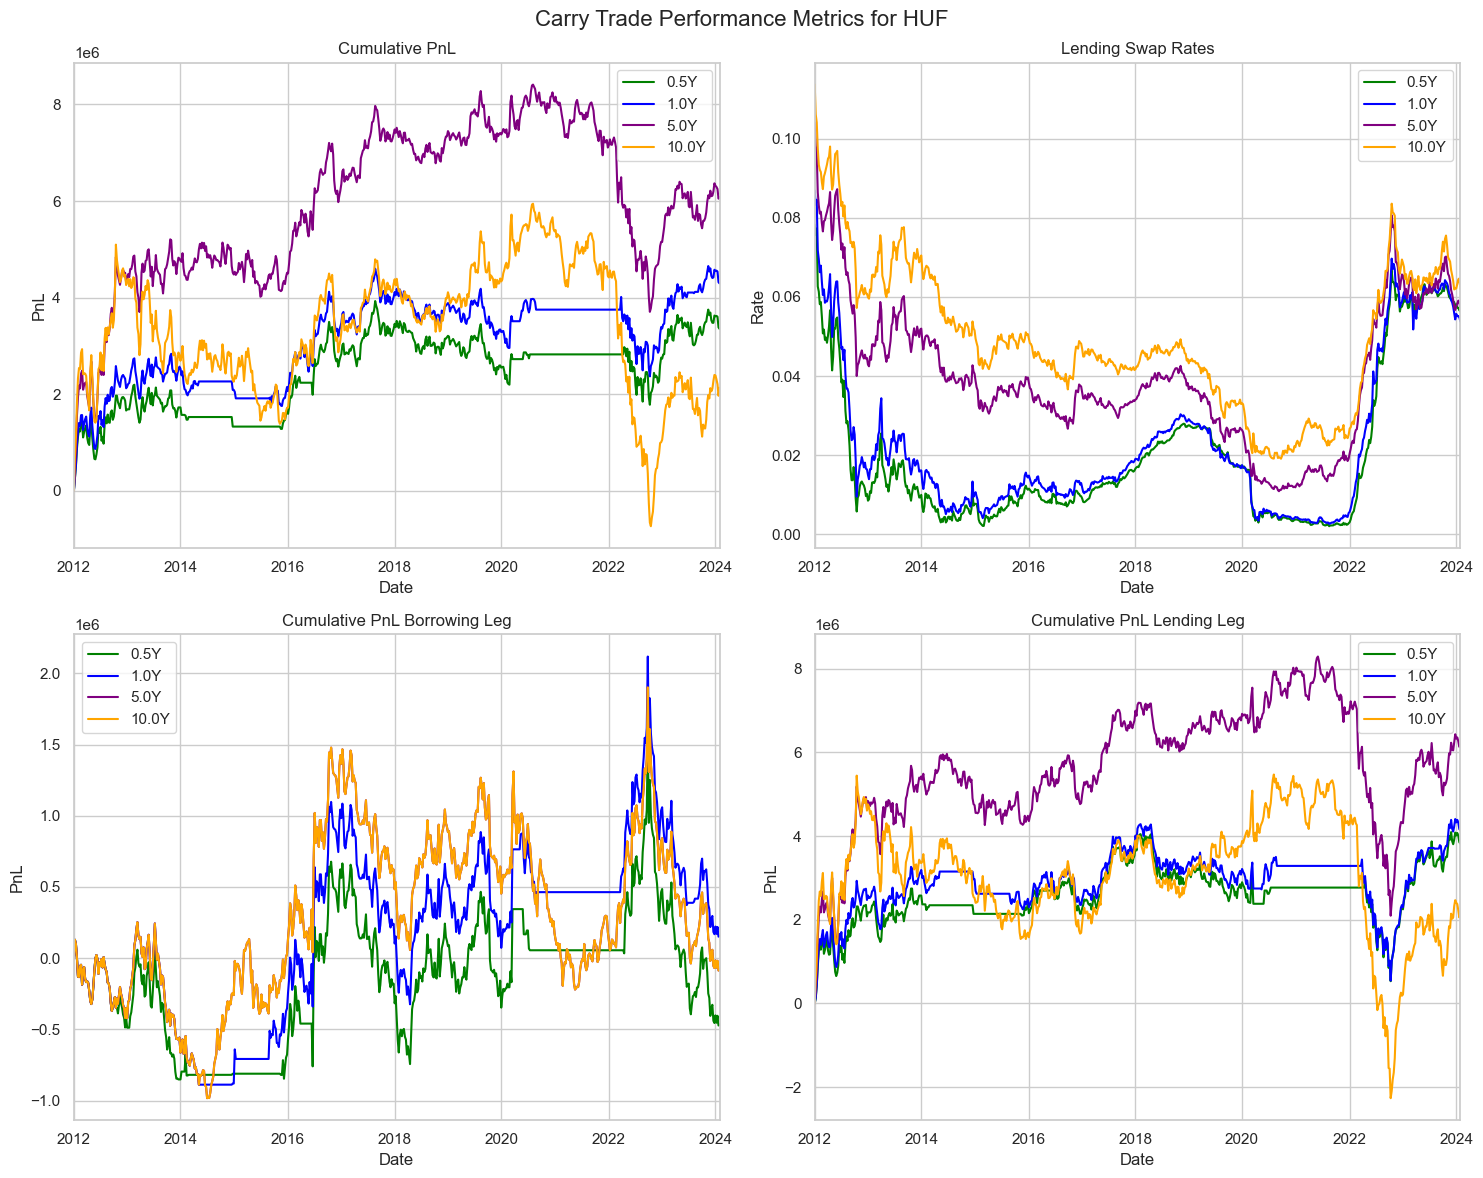

0.5     1.0     5.0     10.0
Total Cumulative PnL - HUF  $3.35M  $4.29M  $6.08M  $2.13M

In [26]:
PnL_HUF, returns_HUF = plot_and_summarize_carry_trades(carry_trades_HUF, 'HUF')

By looking at the different plots, we can see that the best swap rate maturity for our strategy is the 5Y. The cumulative PnL is the highest with about US$6M. The PnL on the borrowing leg is very close across the different maturities, and we clearly identify the movement of the foreign exchange rate. Something interesting to note is the fact that for 2 maturities, we can identify some periods where we stopped trading. This means that the spread (difference between the lending and borrowing swap rates) was lower than 50bps, which is our threshold to open a position. Therefore, we did not trade because the environment was not favorable for our strategy. Now that we identified that our strategy was best for the 5Y maturity, we can have a closer look at this particular strategy.

The last thing we can observe is that the borrowing leg only depends on the foreign exchange rate and the short maturity swap rate OIS, therefore, if they are different, it means that the strategy having a borrowing leg diverging from the other ones experiences some periods where we stopped trading. This is the case here.

PnL Borrow Leg  Cumulative PnL Borrow Leg  Cumulative Interest  \
Date                                                                         
2024-01-03    53598.693589              -15355.235497        -1.293557e+06   
2024-01-10   -51447.224481              -66802.459979        -1.302354e+06   
2024-01-17    48627.339081              -18175.120898        -1.311040e+06   
2024-01-24   -68129.914956              -86305.035854        -1.319856e+06   
2024-01-31     6827.690188              -79477.345666        -1.328586e+06   

            PnL Lending Leg  Cumulative PnL Lending Leg      Total PnL  \
Date                                                                     
2024-01-03   -103497.260465                6.332133e+06  -49898.566876   
2024-01-10     26626.002419                6.358759e+06  -24821.222062   
2024-01-17    -91878.685362                6.266881e+06  -43251.346281   
2024-01-24   -131900.770548                6.134980e+06 -200030.685504   
2024-01-31     27170.799836                6.162151e+06   33998.490024   

            Cumulative PnL  Strategy Return  
Date                                         
2024-01-03    6.316778e+06        -0.024949  
2024-01-10    6.291957e+06        -0.012411  
2024-01-17    6.248706e+06        -0.021626  
2024-01-24    6.048675e+06        -0.100015  
2024-01-31    6.082673e+06         0.016999

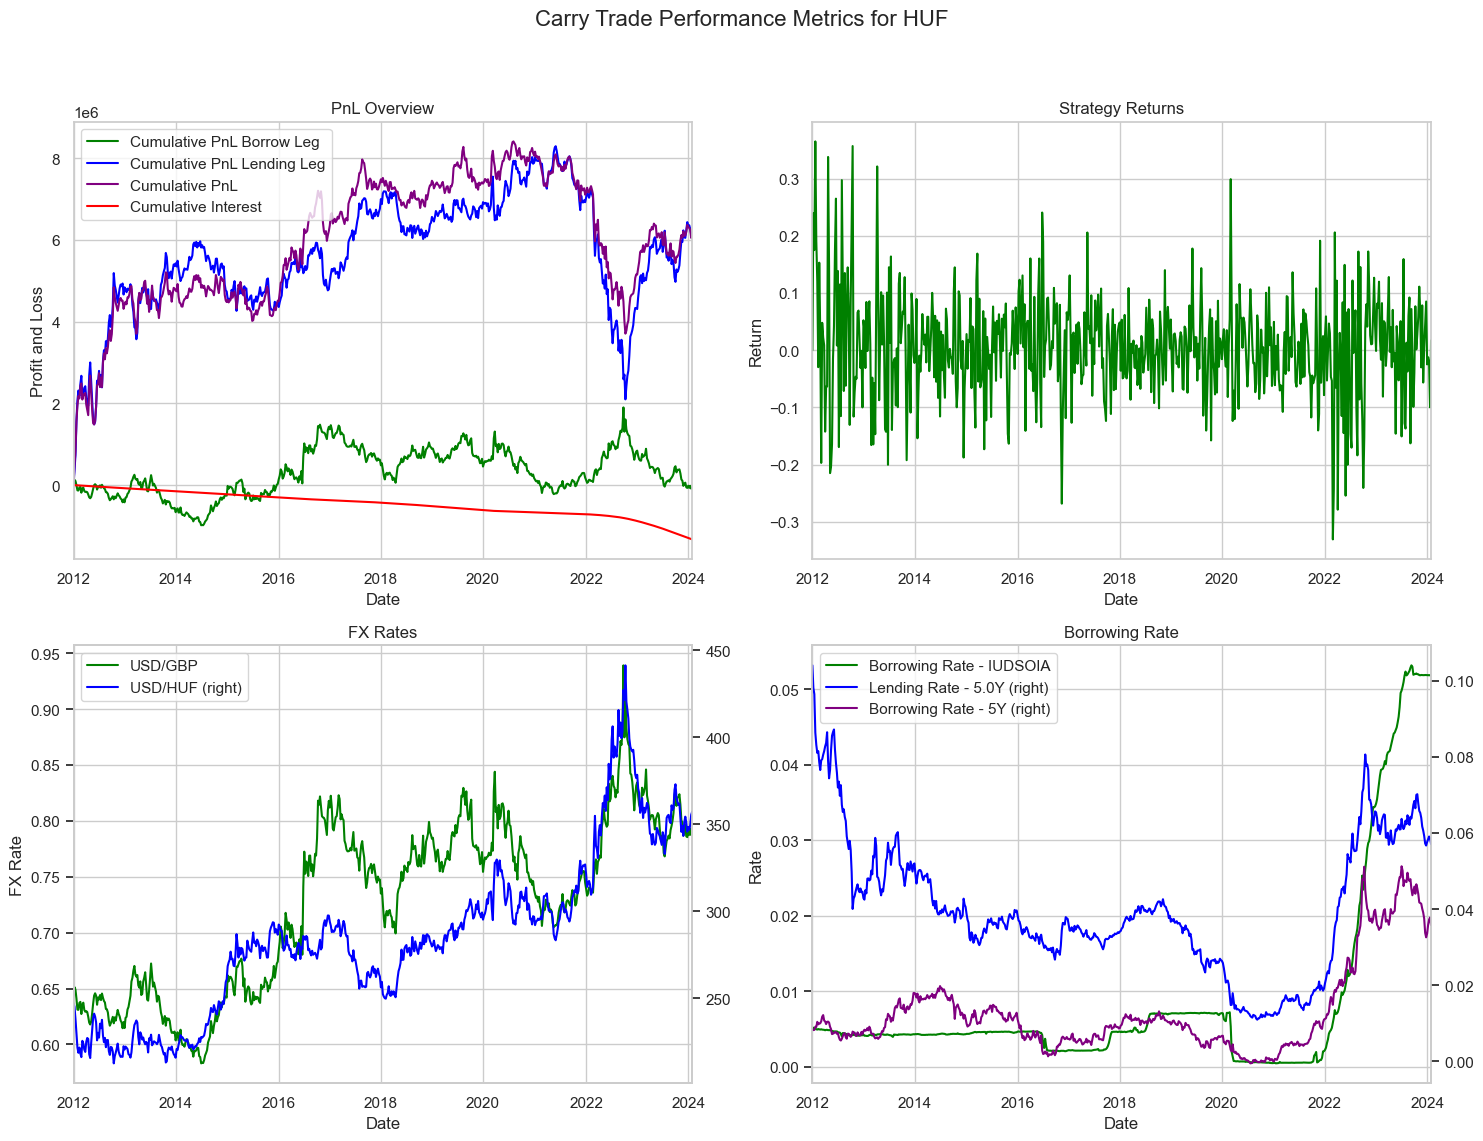

The cumulative profit and loss is $6082673.48.
The return on capital for the last period is 304.13%.


In [27]:
plot_carry_trade_performance(carry_trades_HUF[5.0], 'HUF')

Using the 5Y swap rate, we can see that the strategy has been profitable over the period. We do not have any period where we stopped trading, which indicates that the spread was always favorable or at least as wide as what we wanted it to be. Both currencies have been moving with the same dynamics in that period, they look very correlated. So as the swap rates. The large movements in the foreign exchange rates are being observed in the cumulative PnL of the borrowing leg and lending leg. Especially in late 2022, when the USD appreciated against the GBP, allowing us to make profit on the borrowing leg. But at the same time, the HUF also depreciated against the UD, which made us lose money on the lending leg.

##### 4.1.2. Egyptian Pound (EGP)

The Egyptian Pound (EGP) has experienced significant volatility since 2012, largely due to political instability, economic challenges, and structural reforms in Egypt. Following the 2011 revolution, Egypt's economy faced downturns, leading to a foreign currency shortage, inflation, and a black market for dollars. In November 2016, the Central Bank of Egypt floated the EGP to secure a $12 billion IMF loan, leading to a substantial devaluation of the currency and a spike in inflation. However, this move was also part of broader economic reforms aimed at stabilizing the economy, attracting foreign investment, and improving Egypt's foreign exchange reserves. Over the years, these measures have led to periods of recovery and growth, though the EGP has continued to face pressure due to external debts, global economic conditions, and the impacts of the COVID-19 pandemic.

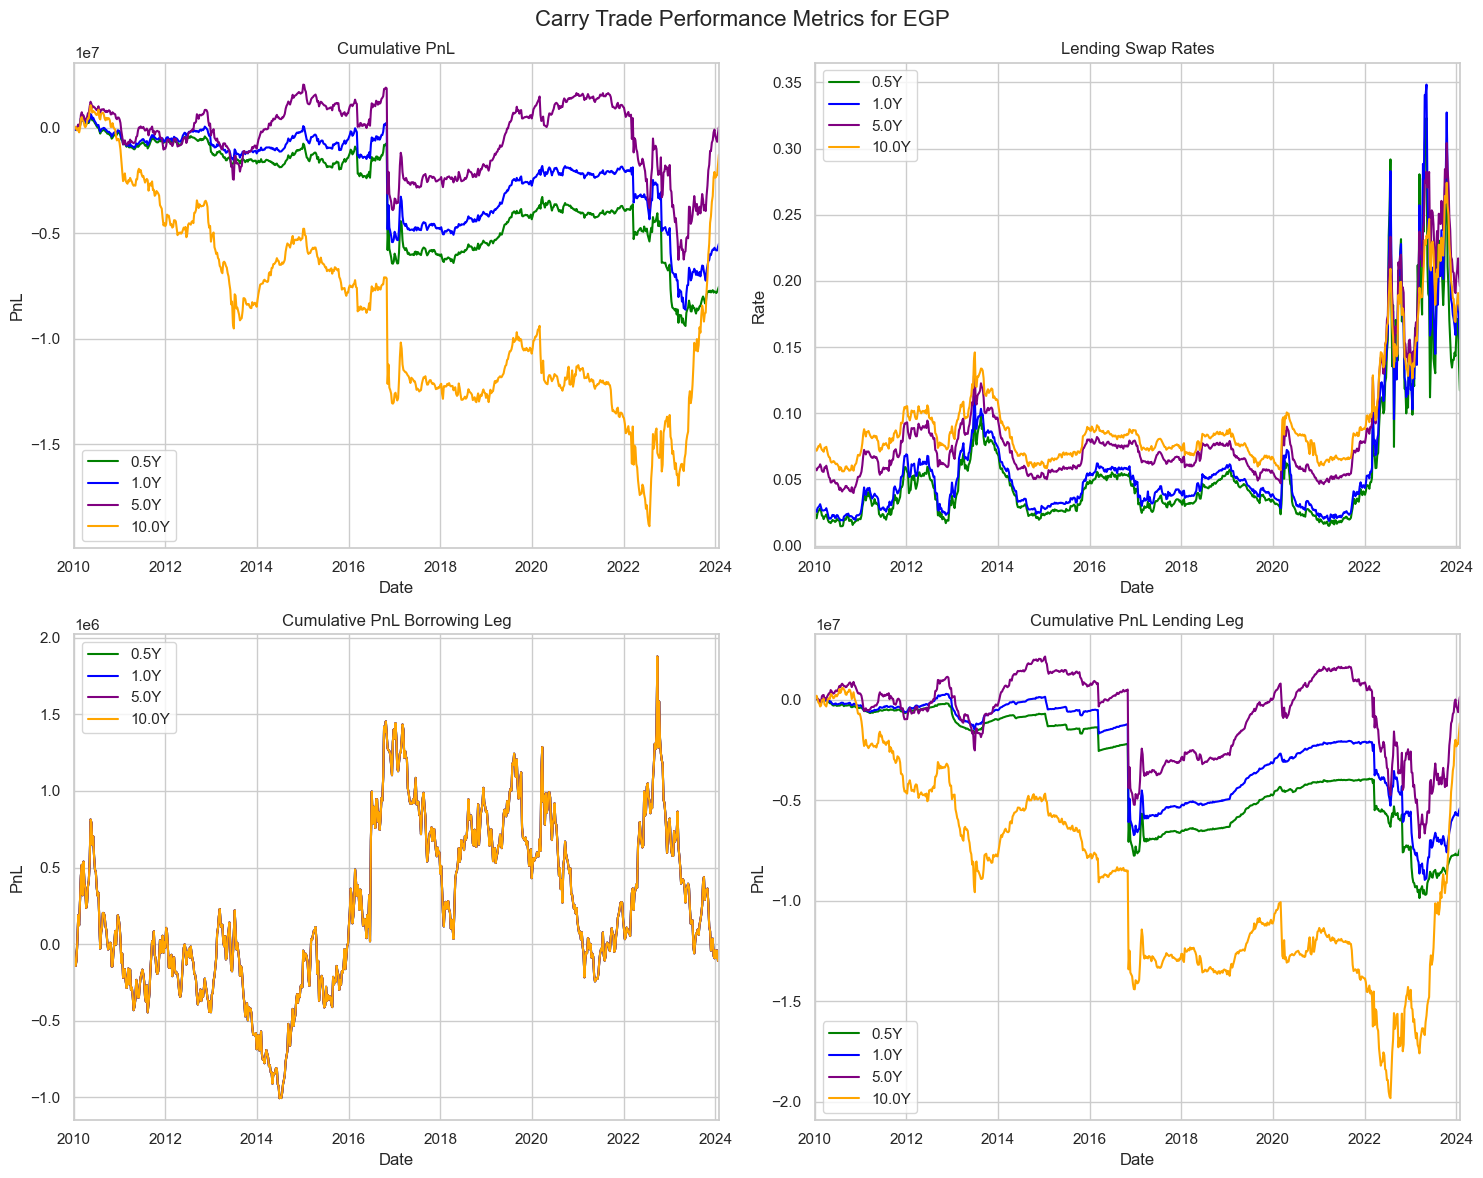

0.5      1.0     5.0      10.0
Total Cumulative PnL - EGP  $-7.53M  $-5.49M  $0.04M  $-1.26M

In [28]:
PnL_EGP, returns_EGP = plot_and_summarize_carry_trades(carry_trades_EGP, 'EGP')

As said earlier, we only see one same line for the different borrowing legs meaning that all the strategies traded at the same time. There is no a strategy that experienced a period where we stopped trading. The cumulative PnL of the lending leg on the contrary is very different across the different maturities. It's experienced a lot of volatility recently due to the large movements in the swap rates since 2022.

In terms of foreign exchange, we can see a large movement in late 2016 on the lending leg, due to the currency when the Central Bank of Egypt floated the EGP in November 2016, and also because we do not identify a movement of that magnitude in the swap rates. In the borrowing leg, we have the same observation as before, where in late 2022, the USD appreciated against the GBP, allowing us to make profit on that same leg.

The cumulative PnL of the strategy on the EGP is on average very negative, even if it seems like it is recovering to make a profit in 2023 on the 5Y maturity version of our strategy. It suffers from a large loss of about US$5M in November 2016. While the 5Y version of our strategy is the best performer, with a small positive profit at the end, the 10Y version is the worst performer. Even though the 5Y version of our strategy is the best performer, it is still not very profitable (without trading costs), and we can see that the strategy is not working well on the EGP. Last thing we can see, the 10Y version is recovering a lot in 2023 and almost manages to reach the 5Y PnL.

PnL Borrow Leg  Cumulative PnL Borrow Leg  Cumulative Interest  \
Date                                                                         
2024-01-03    53598.693589              -38961.809131        -1.454502e+06   
2024-01-10   -51447.224481              -90409.033613        -1.463299e+06   
2024-01-17    48627.339081              -41781.694532        -1.471986e+06   
2024-01-24   -68129.914956             -109911.609488        -1.480802e+06   
2024-01-31     6827.690188             -103083.919300        -1.489532e+06   

            PnL Lending Leg  Cumulative PnL Lending Leg      Total PnL  \
Date                                                                     
2024-01-03   -372148.506655              -359104.371420 -318549.813066   
2024-01-10    -68942.170919              -428046.542339 -120389.395400   
2024-01-17   -187362.162635              -615408.704973 -138734.823554   
2024-01-24    473385.010662              -142023.694312  405255.095706   
2024-01-31    283975.258598               141951.564286  290802.948785   

            Cumulative PnL  Strategy Return  
Date                                         
2024-01-03  -398066.180551        -0.159275  
2024-01-10  -518455.575951        -0.060195  
2024-01-17  -657190.399505        -0.069367  
2024-01-24  -251935.303800         0.202628  
2024-01-31    38867.644986         0.145401

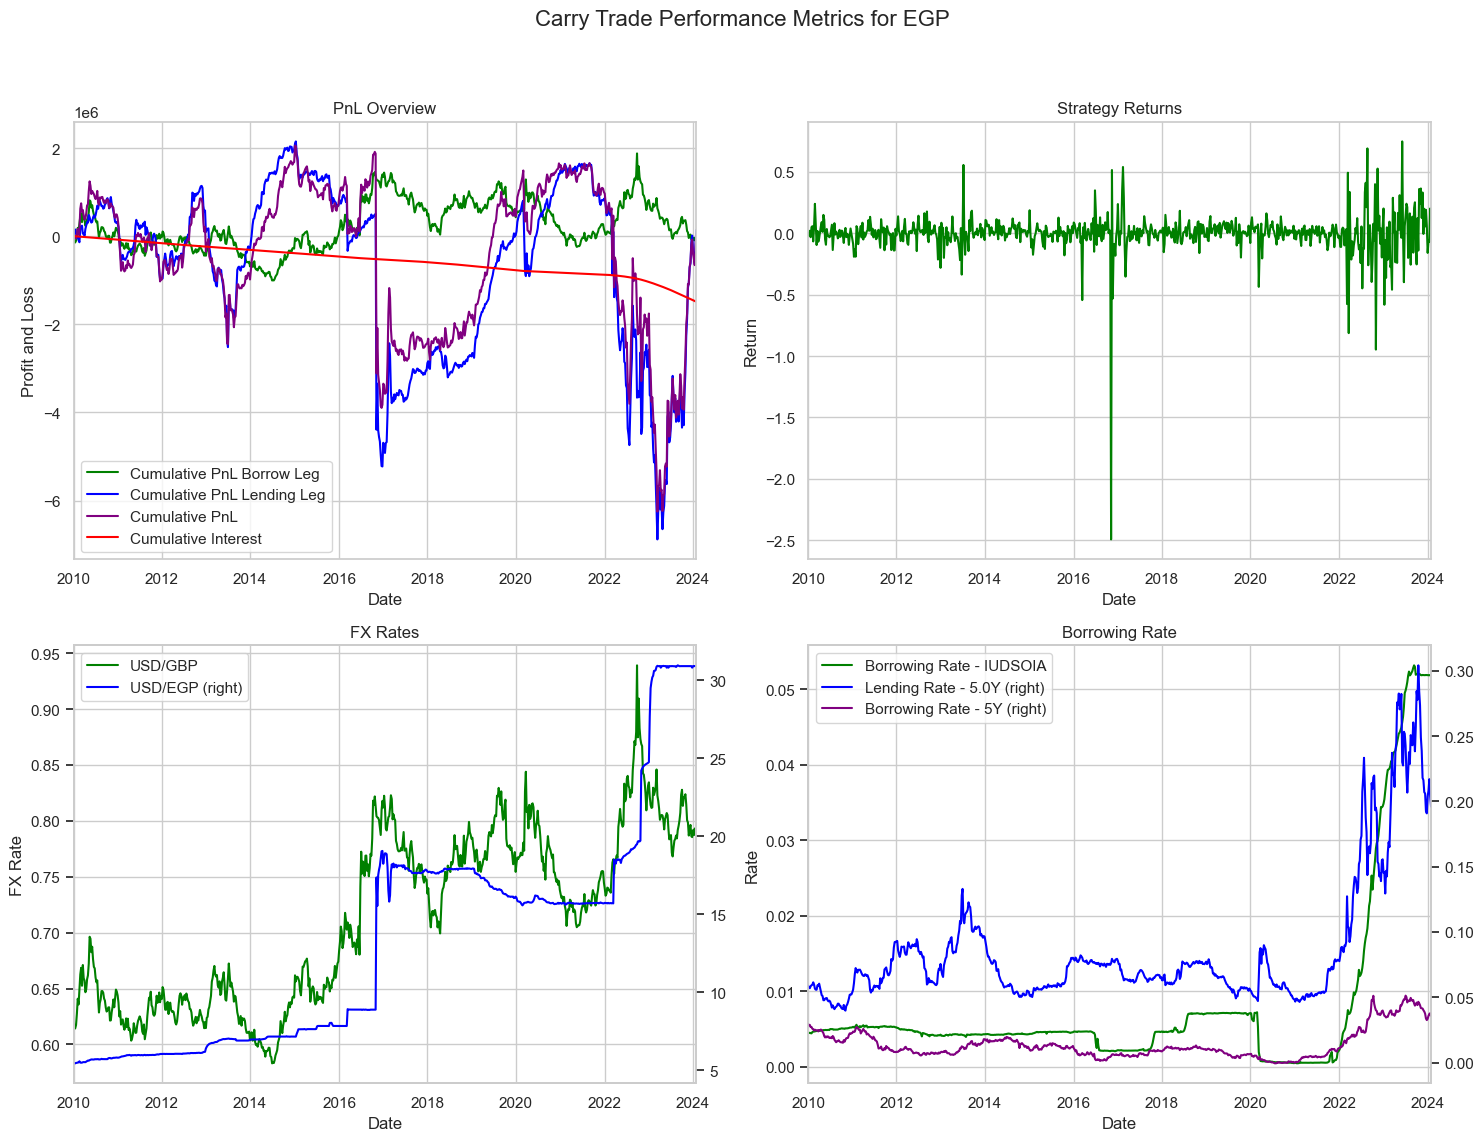

The cumulative profit and loss is $38867.64.
The return on capital for the last period is 1.94%.


In [29]:
plot_carry_trade_performance(carry_trades_EGP[5.0], 'EGP')

The best among the worst, the 5Y version suffers from 2 large drawdowns in 2016 and 2022, but it manages to recover and make a small profit by the end of the period. As we said earlier and as it can be observed on the foreign exchange of the EGP, the November 2016 event impacted a lot the currency. This had the consequence that the EGP depreciated drastically against the USD, which made us lose a lot of money on the lending leg.

Starting in 2022, the EGP has again started deprecriating a lot against the USD. Egypt is experiencing an economic crisis that has resulted in fewer U.S. dollars and other hard currencies available in the market. From 2020 to 2022, the COVID-19 pandemic negatively impacted Egypt’s two largest foreign currency generators—tourism and the oil and gas sector. Both started to rebound in 2022, but in 2023 both sectors are still struggling to regain their pre-COVID revenue. This environment has been reflected in the change in the foreign exchange rate, causing us to lose more than US$6M in less than a year.

##### 4.1.3. Costa Rican Colon (CRC)

Since 2012, the Costa Rican Colon (CRC) has experienced fluctuations reflective of broader economic trends and policy shifts in Costa Rica. The Central Bank of Costa Rica (BCCR) has implemented a managed float exchange rate system, allowing the colon's value to fluctuate within a predetermined band, aiming to control inflation and stabilize the economy. Over the years, the CRC has faced depreciation and appreciation pressures due to factors like changes in international commodity prices, tourism flows, and foreign direct investment. Economic policies, including fiscal reforms and measures to address the fiscal deficit, have also played a crucial role in influencing the colon's value against major currencies.

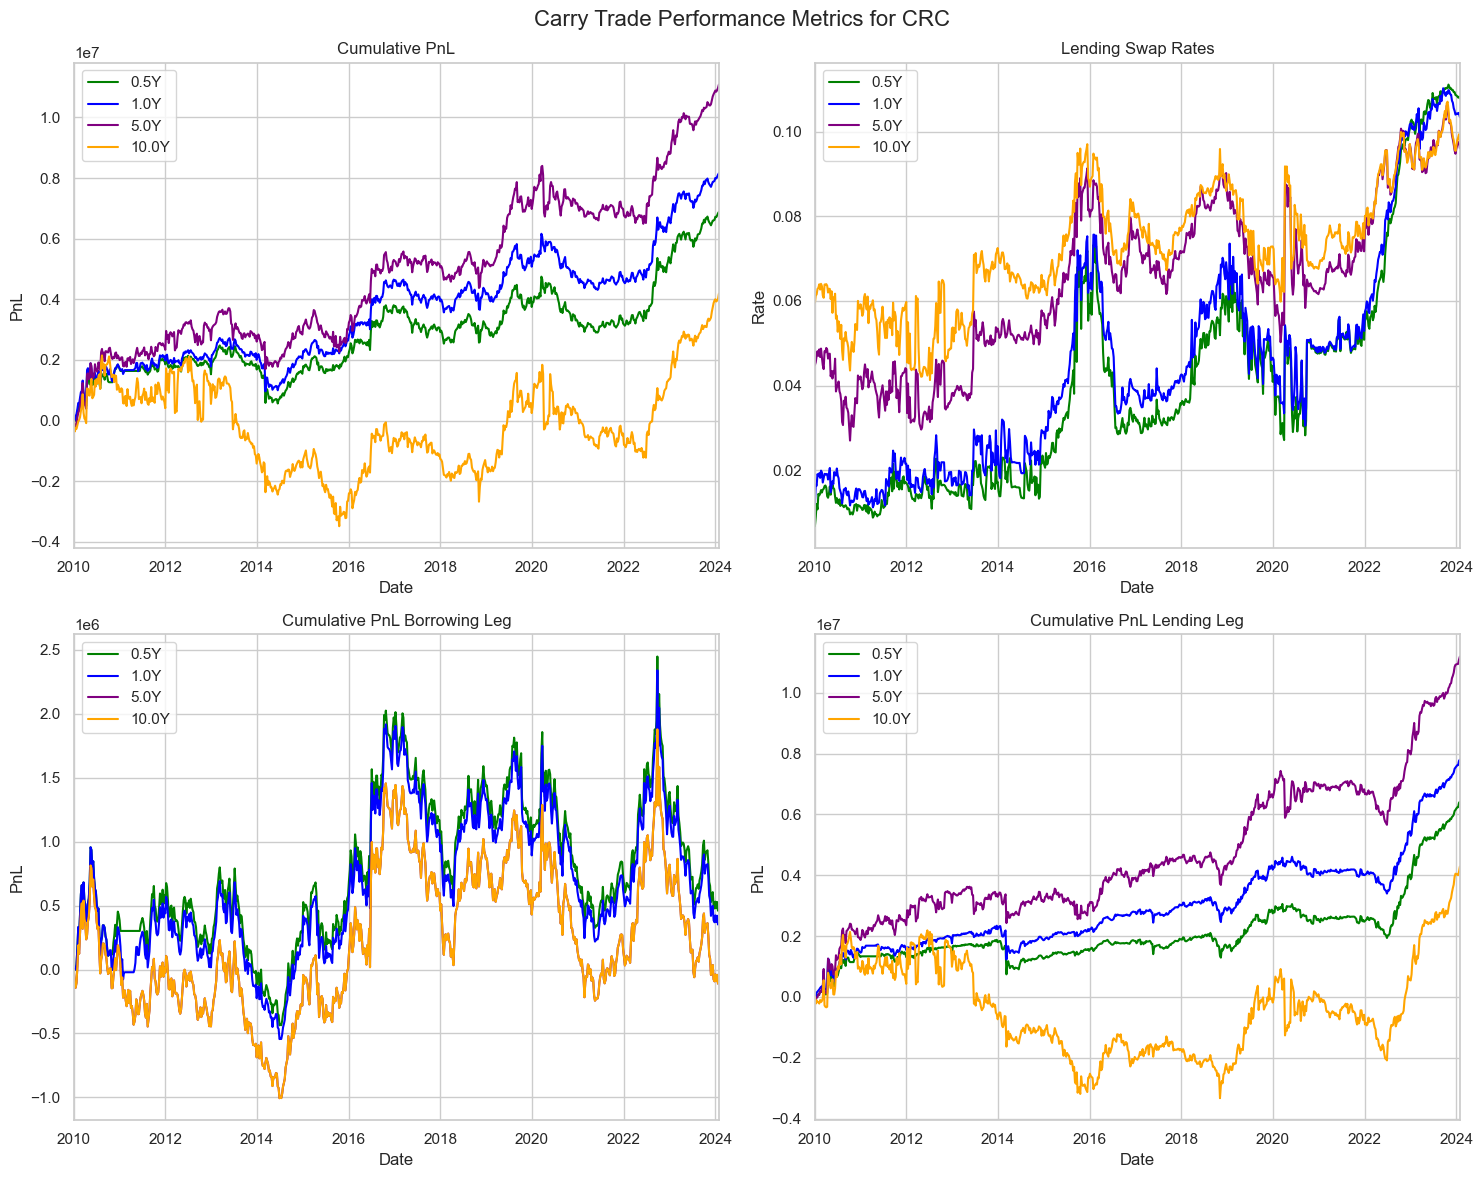

0.5     1.0      5.0     10.0
Total Cumulative PnL - CRC  $6.88M  $8.16M  $11.09M  $4.18M

In [30]:
PnL_CRC, returns_CRC = plot_and_summarize_carry_trades(carry_trades_CRC, 'CRC')

Same analysis as what we did until now. The different strategies do not all trade all the time. The 10Y version is the worst performer, while the 5Y is still the best performer. Apart from the 10Y version, all the other strategies show a positive cumulative PnL on the entire period. The same movements as for the previously analyzed currencies can be identified on the borrowing leg, linked to the foreign exchange rate movements between USD and GBP.

The lending leg here is much less volatile than what has been observed for the two previous ones. A small drop in 2016 is to relate to the corresponding jump in swap rate at the same time. Let's take a closer look at the 5Y version to identify any foreign exchange movements that could have impacted the strategy too.

PnL Borrow Leg  Cumulative PnL Borrow Leg  Cumulative Interest  \
Date                                                                         
2024-01-03    53598.693589              -38961.809131        -1.454502e+06   
2024-01-10   -51447.224481              -90409.033613        -1.463299e+06   
2024-01-17    48627.339081              -41781.694532        -1.471986e+06   
2024-01-24   -68129.914956             -109911.609488        -1.480802e+06   
2024-01-31     6827.690188             -103083.919300        -1.489532e+06   

            PnL Lending Leg  Cumulative PnL Lending Leg      Total PnL  \
Date                                                                     
2024-01-03     10368.748533                1.092870e+07   63967.442121   
2024-01-10     14163.215917                1.094286e+07  -37284.008564   
2024-01-17      1943.794106                1.094481e+07   50571.133187   
2024-01-24    138185.566877                1.108299e+07   70055.651921   
2024-01-31    105512.716575                1.118851e+07  112340.406763   

            Cumulative PnL  Strategy Return  
Date                                         
2024-01-03    1.088974e+07         0.031984  
2024-01-10    1.085246e+07        -0.018642  
2024-01-17    1.090303e+07         0.025286  
2024-01-24    1.097308e+07         0.035028  
2024-01-31    1.108542e+07         0.056170

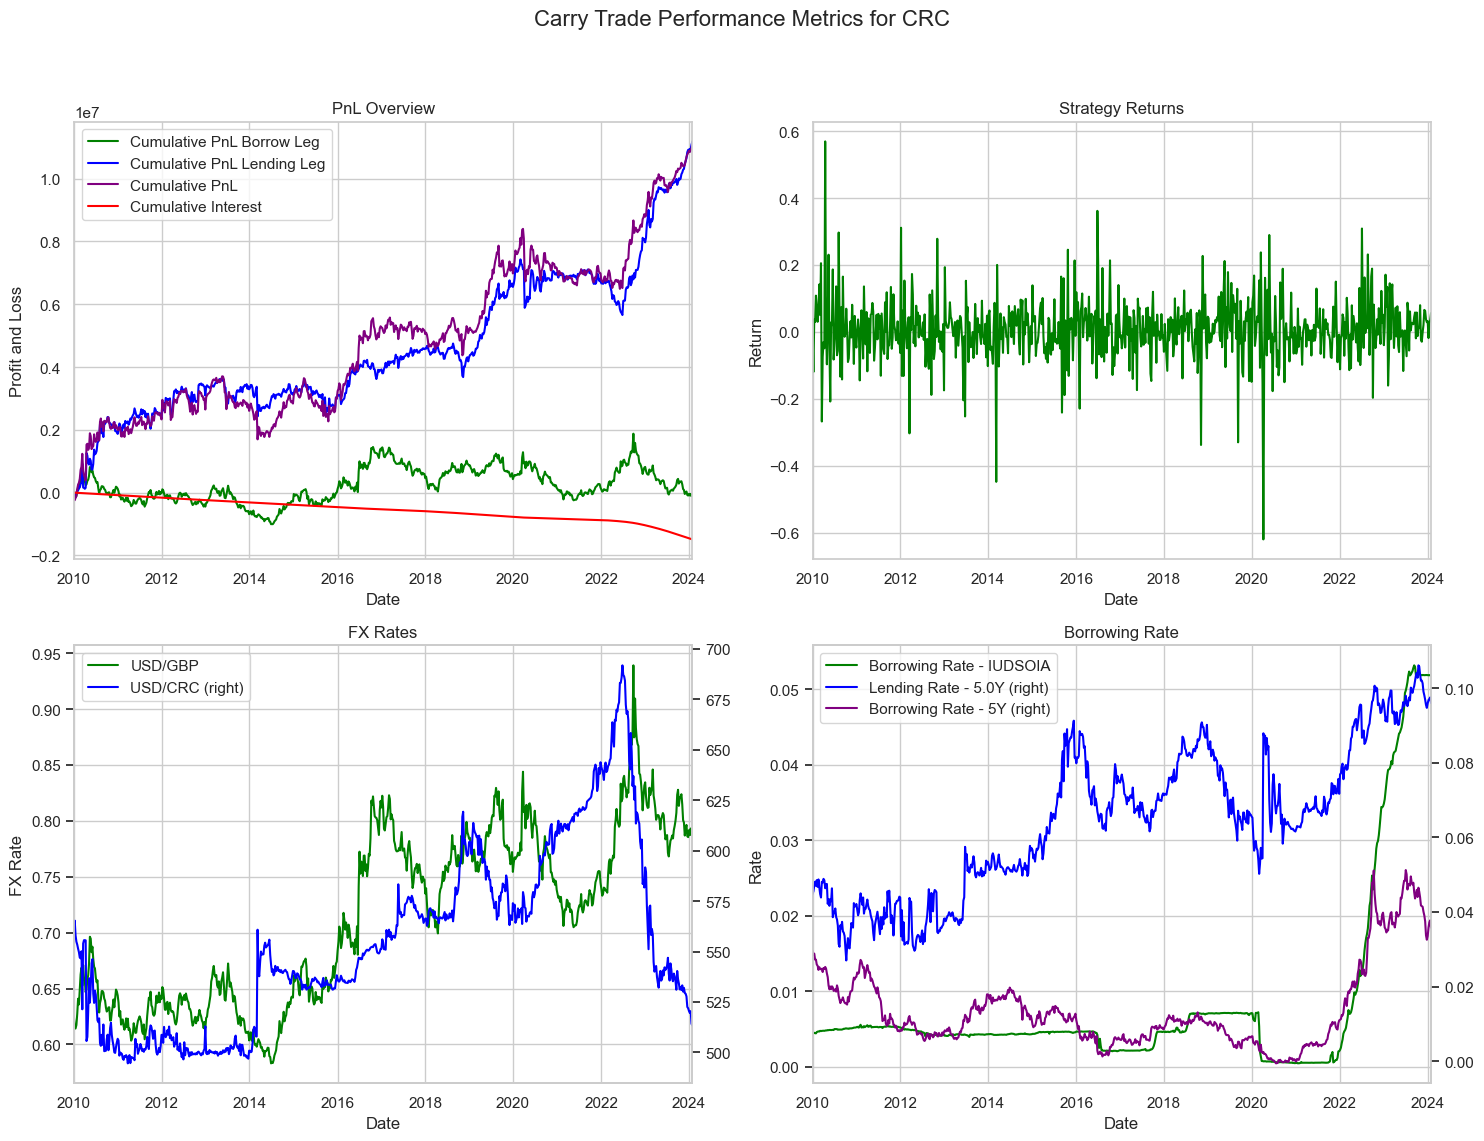

The cumulative profit and loss is $11085422.47.
The return on capital for the last period is 554.27%.


In [31]:
plot_carry_trade_performance(carry_trades_CRC[5.0], 'CRC')

Nothing very striking here, apart from the small jump observed in the currency in early 2014, when the USD appreciated against the CRC. Otherwise, it looks like the two foreign exchange rates have been moving quite similarly. 

The 5Y version of our strategy has been very profitable, with a cumulative PnL of more than US$11M. It has benefited a lot from high lending rates and more recently from the depreciation of USD against the CRC. The foreign exchange has returned to its level of 2014. It has allowed us to make a lot of profit on the lending leg from both favorable foreign exchange rate movements and high lending rates.

##### 4.1.4. Romanian Leu (RON)

Since 2012, the Romanian Leu (RON) has been the currency of Romania, continuing its role in the country's economy. Since 2012, Romania has seen moderate economic growth, with the Leu experiencing various degrees of fluctuation against major currencies such as the Euro (EUR) and the US Dollar (USD), influenced by both domestic factors like fiscal policies, inflation rates, and political stability, as well as external economic conditions. Romania's integration into European Union markets has further impacted the Leu, with discussions about adopting the Euro as part of the Eurozone, although a specific timeline for this transition has remained uncertain. The National Bank of Romania has played a key role in managing monetary policy to ensure stability and control of inflation, contributing to the overall resilience of the Leu in the face of regional and global economic challenges.

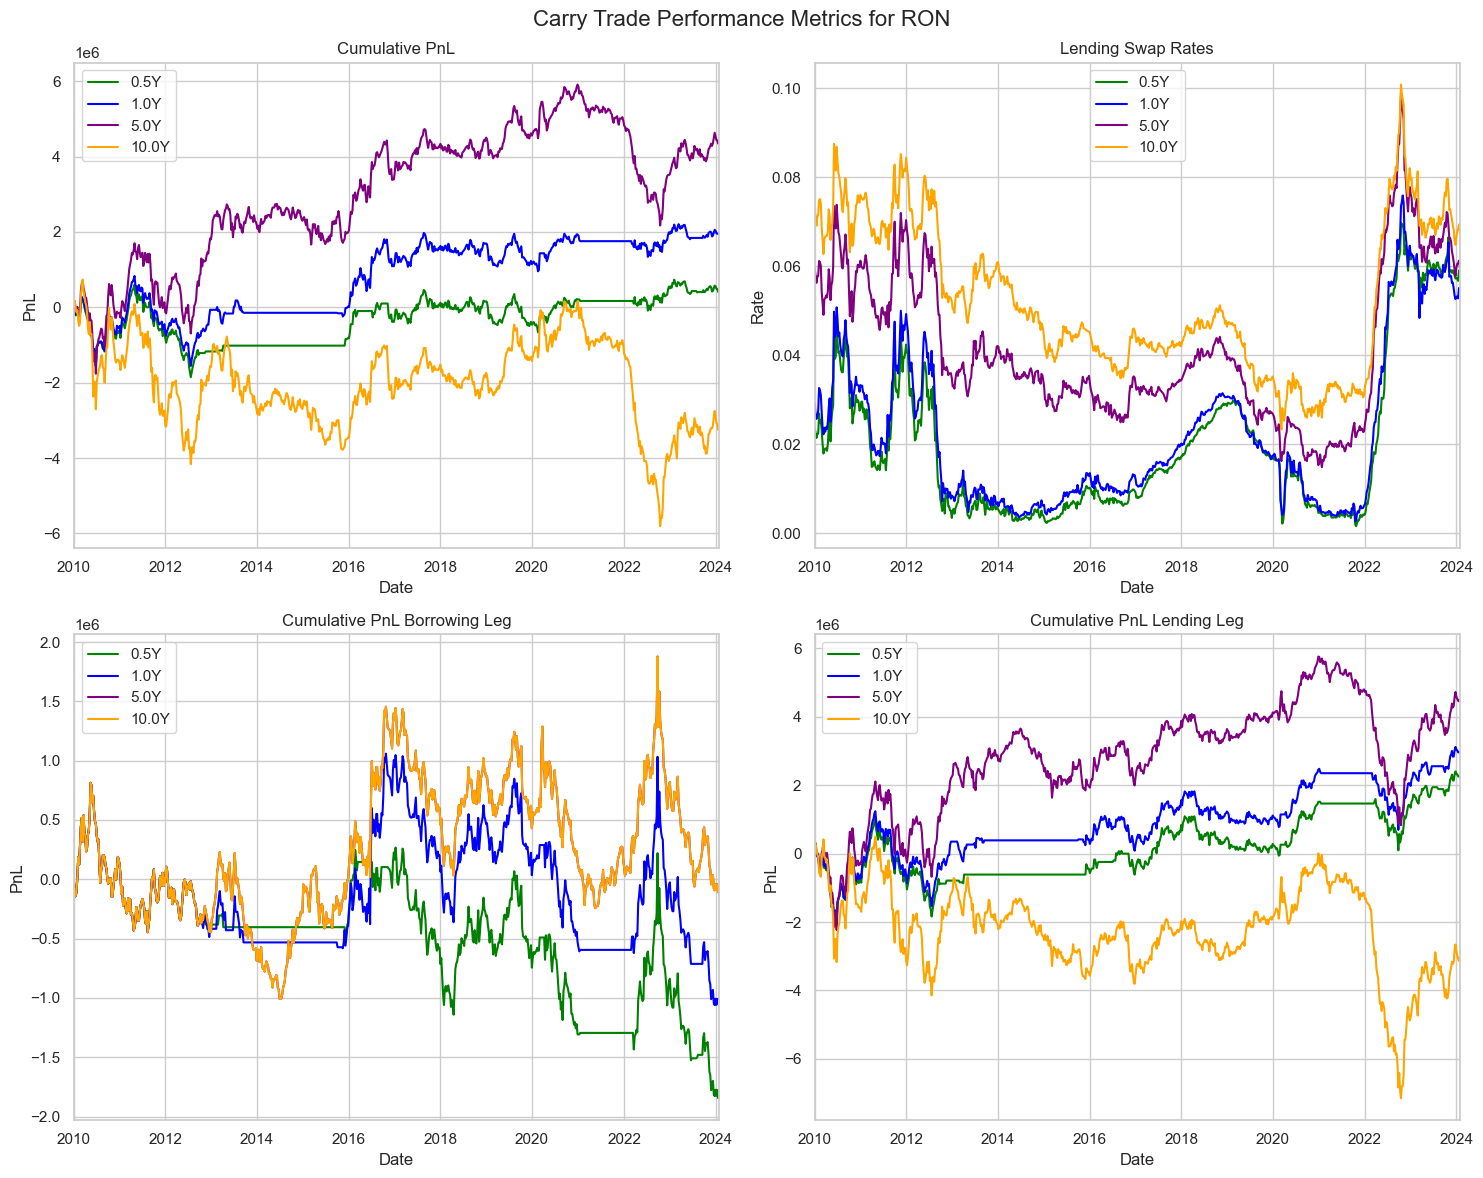

0.5     1.0     5.0      10.0
Total Cumulative PnL - RON  $0.40M  $1.94M  $4.40M  $-3.14M

In [32]:
PnL_RON, returns_RON = plot_and_summarize_carry_trades(carry_trades_RON, 'RON')

The strategies on the Romanian Leu are not very profitable, and the 10Y version does not even manage to get a positive cumulative PnL on the entire period. The 5Y version is again the best performer while both the 1Y and 0.5Y versions both stop trading for more than 2 years in 2014 to 2016 and again for an entire year in 2021. This is linked to the very low spread between the lending and borrowing swap rates, with a lending rate close to 0 in those same periods, which is not favorable for our strategy. The large upward movement in the lending leg in 2022 also negatively impacted our lending leg PnL until it stabilized in 2023 and that we started being able to profit again from those high lending rates.

PnL Borrow Leg  Cumulative PnL Borrow Leg  Cumulative Interest  \
Date                                                                         
2024-01-03    53598.693589              -38961.809131        -1.454502e+06   
2024-01-10   -51447.224481              -90409.033613        -1.463299e+06   
2024-01-17    48627.339081              -41781.694532        -1.471986e+06   
2024-01-24   -68129.914956             -109911.609488        -1.480802e+06   
2024-01-31     6827.690188             -103083.919300        -1.489532e+06   

            PnL Lending Leg  Cumulative PnL Lending Leg      Total PnL  \
Date                                                                     
2024-01-03   -145093.936359                4.579178e+06  -91495.242770   
2024-01-10    -48845.047861                4.530333e+06 -100292.272342   
2024-01-17    -63495.001259                4.466838e+06  -14867.662179   
2024-01-24    -11695.514121                4.455142e+06  -79825.429078   
2024-01-31     45403.578428                4.500546e+06   52231.268616   

            Cumulative PnL  Strategy Return  
Date                                         
2024-01-03    4.540216e+06        -0.045748  
2024-01-10    4.439924e+06        -0.050146  
2024-01-17    4.425056e+06        -0.007434  
2024-01-24    4.345231e+06        -0.039913  
2024-01-31    4.397462e+06         0.026116

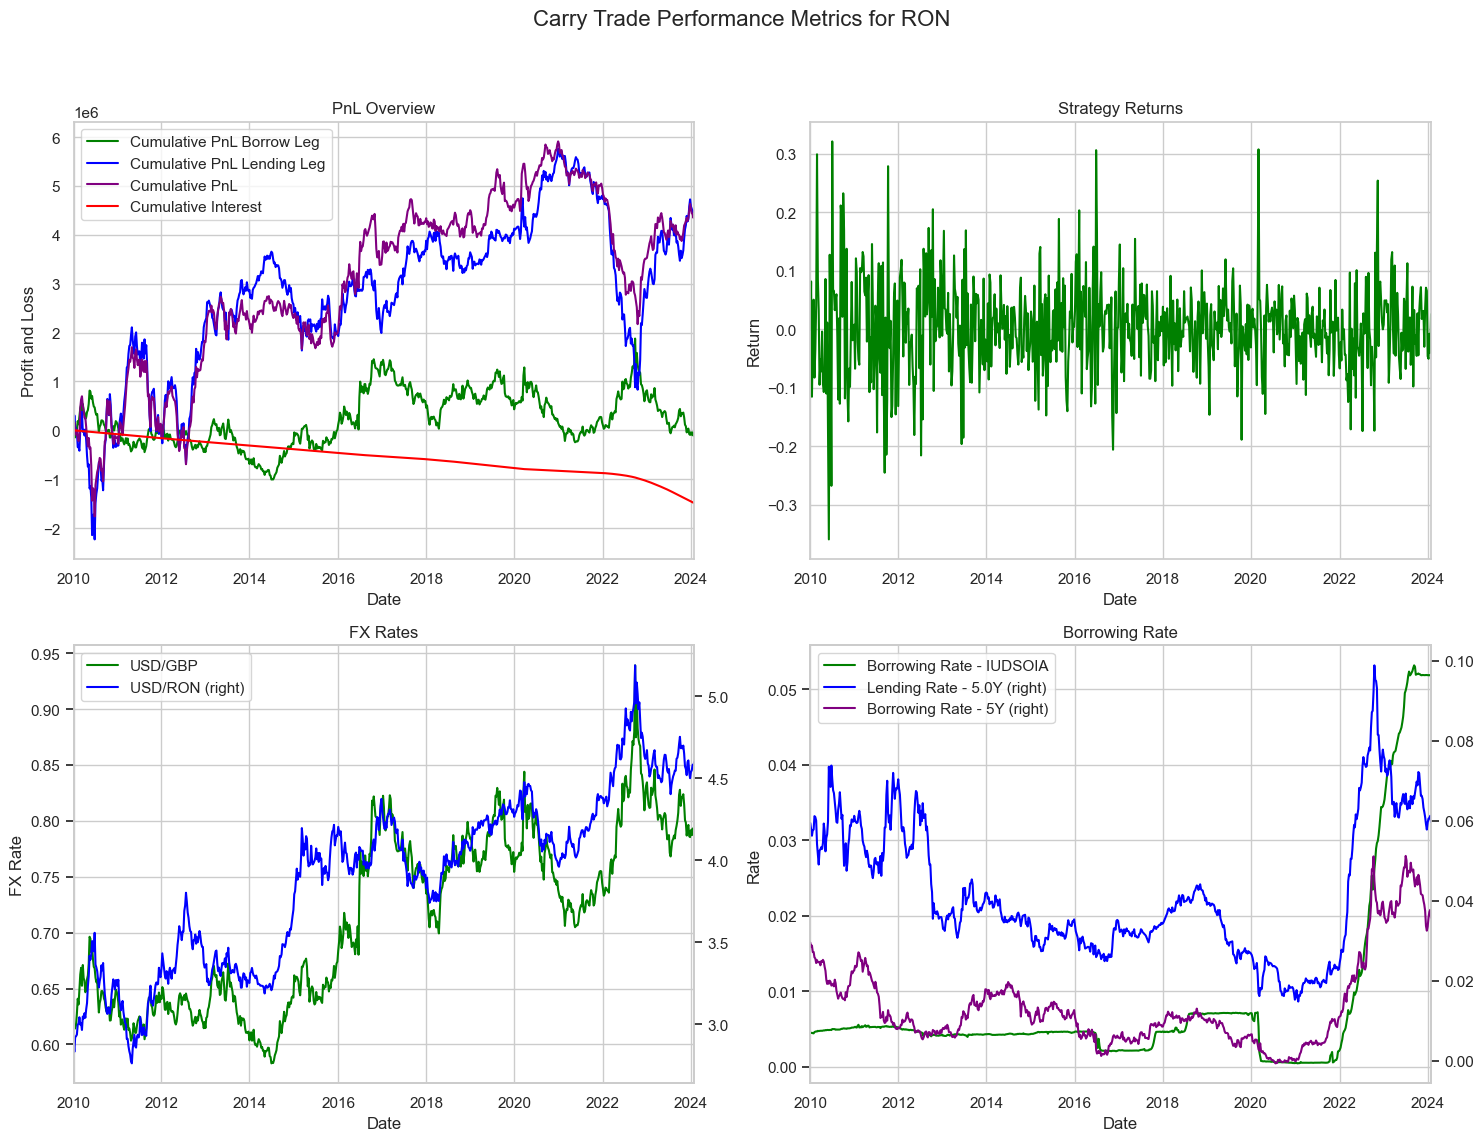

The cumulative profit and loss is $4397461.90.
The return on capital for the last period is 219.87%.


In [33]:
plot_carry_trade_performance(carry_trades_RON[5.0], 'RON')

Looking closer at the strategy using maturity of 5Y for the swap rates, we can see that foreign exchange rates and swap rates have been moving quite similarly. Probably related to the fact that both countries we are working with in our borrowing and lending leg are in Europe and experience the close economic environments.

When the USD appreciated against GBP, we experienced a profit in our lending leg, while the depreciation of the RON against the USD caused us to lose money on the borrowing leg. Nevertheless, those parallel movements have averaged out a little, allowing our strategy to be profitable, with a cumulative PnL of more than US$4.3M.

#### 4.2. PnL Comparison

As observed from individual analysis, in terms of PnL, the EGP strategy has been the worst performer, while the CRC strategy has been the best performer. The HUF and RON strategies have been in between, with the HUF strategy being the second-best performer and the RON strategy being the third-best performer.

The 5Y version of the strategy has been the best performer for all the currencies, while the 10Y version has been the worst performer for all the currencies. The 1Y and 0.5Y versions have been in between, with the 1Y version being the second-best performer and the 0.5Y version being the third-best performer.

We can summarize the performance of the different strategies as follows:

In [34]:
PnL_strats = pd.concat([PnL_HUF, PnL_EGP, PnL_CRC, PnL_RON], axis=1)
PnL_strats.loc['Mean'] = PnL_strats.mean()
PnL_strats.applymap(lambda x: "${:,.2f}M".format(x/1000000))

Total Cumulative PnL - HUF Total Cumulative PnL - EGP  \
0.5                      $3.35M                    $-7.53M   
1.0                      $4.29M                    $-5.49M   
5.0                      $6.08M                     $0.04M   
10.0                     $2.13M                    $-1.26M   
Mean                     $3.97M                    $-3.56M   

     Total Cumulative PnL - CRC Total Cumulative PnL - RON  
0.5                      $6.88M                     $0.40M  
1.0                      $8.16M                     $1.94M  
5.0                     $11.09M                     $4.40M  
10.0                     $4.18M                    $-3.14M  
Mean                     $7.58M                     $0.90M

#### 4.3. Performance and Risk Metrics

Now that we judged our strategies based on their PnL, we can try to look at some performance and risk metrics to have a better understanding of the dynamics of our strategies.

In [35]:
def performance_summary(return_data, rf=None, rb=None, annualization=1):
    summary_stats = return_data.mean().to_frame('Mean').apply(lambda x: x * annualization)
    summary_stats['Volatility'] = return_data.std().apply(lambda x: x * np.sqrt(annualization))

    if rf is not None:
        summary_stats['Sharpe Ratio'] = (return_data - rf).mean() / summary_stats['Volatility'] * annualization
    else:
        summary_stats['Sharpe Ratio'] = summary_stats['Mean'] / summary_stats['Volatility']

    if rb is not None:
        summary_stats['Information Ratio'] = (return_data - rf).mean() / (return_data - rf).std() * np.sqrt(
            annualization)

        downside_returns = np.where(return_data < rb, return_data - rb, 0)
        downside_deviation = np.sqrt(np.mean(downside_returns ** 2))

        summary_stats['Sortino Ratio'] = (return_data - rb).mean() / downside_deviation * np.sqrt(annualization)

    summary_stats['Skewness'] = return_data.skew()
    summary_stats['Excess Kurtosis'] = return_data.kurtosis()
    summary_stats['Empirical VaR (0.05)'] = return_data.quantile(.05, axis=0)
    summary_stats['Empirical CVaR (0.05)'] = return_data[return_data <= return_data.quantile(.05, axis=0)].mean()

    wealth_index = 1000 * (1 + return_data).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks) / previous_peaks

    summary_stats['Max Drawdown'] = drawdowns.min()
    summary_stats['Peak'] = [previous_peaks[col][:drawdowns[col].idxmin()].idxmax() for col in previous_peaks.columns]
    summary_stats['Bottom'] = drawdowns.idxmin()

    recovery_date = []
    for col in wealth_index.columns:
        prev_max = previous_peaks[col][:drawdowns[col].idxmin()].max()
        recovery_wealth = pd.DataFrame([wealth_index[col][drawdowns[col].idxmin():]]).T
        recovery_date.append(recovery_wealth[recovery_wealth[col] >= prev_max].index.min())
    summary_stats['Recovery'] = recovery_date

    return summary_stats

In [36]:
returns_strats = pd.concat([returns_HUF, returns_EGP, returns_CRC, returns_RON], axis=1)
performance_summary(returns_strats, annualization=52)  # We have weekly data so we annualized by 52

Mean  Volatility  Sharpe Ratio   Skewness  Excess Kurtosis  \
HUF - 0.5Y   0.138173    0.426187      0.324208   0.141457         2.239351   
HUF - 1.0Y   0.176971    0.456151      0.387965   0.144574         1.928218   
HUF - 5.0Y   0.250633    0.640131      0.391534   0.148925         1.725620   
HUF - 10.0Y  0.087965    0.771516      0.114015   0.201314         1.979976   
EGP - 0.5Y  -0.266263    0.937078     -0.284142 -10.420169       187.309912   
EGP - 1.0Y  -0.194287    0.964802     -0.201375  -9.437203       166.601993   
EGP - 5.0Y   0.001375    1.154035      0.001191  -5.407749        84.484288   
EGP - 10.0Y -0.044685    1.387444     -0.032206  -2.793359        42.202385   
CRC - 0.5Y   0.243516    0.486277      0.500777   0.510947         8.863058   
CRC - 1.0Y   0.288667    0.497876      0.579798   0.481138         8.288400   
CRC - 5.0Y   0.392137    0.646716      0.606352  -0.208852         7.184204   
CRC - 10.0Y  0.148030    0.950639      0.155716  -0.211331         8.484105   
RON - 0.5Y   0.014007    0.309753      0.045219   0.093610         4.589197   
RON - 1.0Y   0.068649    0.351129      0.195510   0.265477         3.693006   
RON - 5.0Y   0.155556    0.551158      0.282235   0.106997         2.210558   
RON - 10.0Y -0.111073    0.713999     -0.155565  -0.053500         3.027455   

             Empirical VaR (0.05)  Empirical CVaR (0.05)  Max Drawdown  \
HUF - 0.5Y              -0.102625              -0.133113     -0.772095   
HUF - 1.0Y              -0.104327              -0.139571     -0.794900   
HUF - 5.0Y              -0.142622              -0.188117     -0.951627   
HUF - 10.0Y             -0.178549              -0.234679     -0.995935   
EGP - 0.5Y              -0.099723              -0.292151     -1.572540   
EGP - 1.0Y              -0.108779              -0.310675     -2.070022   
EGP - 5.0Y              -0.184517              -0.395098     -3.074918   
EGP - 10.0Y             -0.239194              -0.462256     -1.002646   
CRC - 0.5Y              -0.091962              -0.136086     -0.695103   
CRC - 1.0Y              -0.093744              -0.139251     -0.669789   
CRC - 5.0Y              -0.123635              -0.198418     -0.796223   
CRC - 10.0Y             -0.185426              -0.313367     -0.999841   
RON - 0.5Y              -0.069679              -0.103446     -0.743109   
RON - 1.0Y              -0.075887              -0.111788     -0.738827   
RON - 5.0Y              -0.117234              -0.165302     -0.870359   
RON - 10.0Y             -0.161624              -0.226219     -0.998679   

                  Peak     Bottom   Recovery  
HUF - 0.5Y  2017-08-23 2022-10-12        NaT  
HUF - 1.0Y  2017-08-23 2022-10-12        NaT  
HUF - 5.0Y  2017-08-23 2022-10-12        NaT  
HUF - 10.0Y 2012-10-17 2022-10-19        NaT  
EGP - 0.5Y  2010-05-19 2016-11-16        NaT  
EGP - 1.0Y  2010-05-19 2020-03-25        NaT  
EGP - 5.0Y  2010-05-19 2020-03-04        NaT  
EGP - 10.0Y 2010-05-19 2016-11-16        NaT  
CRC - 0.5Y  2013-03-13 2014-06-18 2016-10-05  
CRC - 1.0Y  2013-03-13 2014-06-18 2016-06-29  
CRC - 5.0Y  2020-03-25 2022-06-29 2023-09-20  
CRC - 10.0Y 2010-08-18 2022-06-29        NaT  
RON - 0.5Y  2011-05-04 2012-07-25        NaT  
RON - 1.0Y  2011-05-04 2012-07-25 2016-08-10  
RON - 5.0Y  2020-12-30 2022-10-19        NaT  
RON - 10.0Y 2010-03-17 2022-10-19        NaT

In our initial analysis focusing on performance metrics, it is evident that different strategies yield varying returns and volatilities. For instance, the HUF - 5.0Y strategy exhibits a mean return of 0.250633, indicating a potentially higher reward. However, it also comes with a higher volatility of 0.640131, suggesting greater risk. Comparatively, the HUF - 0.5Y strategy has a lower mean return of 0.138173 and a volatility of 0.426187, indicating a more conservative risk-return profile. Notably, the EGP - 0.5Y strategy shows a negative mean return of -0.266263 with a high volatility of 0.937078, highlighting a significantly risky and underperforming strategy. In a more general way, the strategies on EGP all perform pretty poorly, with a negative or near zero mean return, and with large volatility.

The CRC - 5.0Y strategy stands out with the highest mean return of 0.392137 and a relatively high volatility of 0.646716. Despite its volatility, this strategy also boasts the highest Sharpe Ratio of 0.606352 in the dataset, signaling a superior risk-adjusted return compared to its peers.

From a risk perspective, the dataset indicates significant differences in the risk metrics. The Sharpe Ratio, a crucial metric for assessing risk-adjusted returns, varied widely, with the CRC - 5.0Y strategy achieving the top mark, illustrating its efficiency in balancing risk for higher returns. Conversely, strategies like EGP - 0.5Y demonstrated poor risk-adjusted performance. Max Drawdown, another vital risk metric, showcased the potential losses, with some strategies experiencing substantial drawdowns, pointing to high risk (especially for EGP strategies again).

Skewness and Excess Kurtosis are critical statistical measures that provide deep insights into the distribution and risk characteristics of investment returns, particularly relevant for evaluating carry trade strategies. Carry trades involve borrowing in a currency with a low interest rate and investing in a currency with a higher interest rate, aiming to profit from the interest rate differential. These strategies are inherently exposed to market risks, which can lead to asymmetric return distributions and tail risks, underscored by skewness and kurtosis measures.

Skewness measures the asymmetry of the return distribution around its mean. A positive skew indicates that the tail on the right side (representing higher-than-average returns) is longer or fatter than the left side, suggesting a higher probability of large positive returns. Conversely, a negative skew indicates a longer or fatter tail on the left side (representing lower-than-average returns), implying a higher risk of negative outcomes. For carry trade strategies, a positive skew is desirable as it indicates the potential for large gains, whereas a negative skew signals caution, reflecting the risk of significant losses.

In the dataset, skewness values vary significantly, with some strategies showing positive skew and others negative. For example, the EGP - 0.5Y strategy exhibits a highly negative skew (-10.420169), indicating a substantial risk of experiencing severe negative returns. Such a negative skew in carry trade strategies could be indicative of vulnerability to sudden market downturns or currency devaluations, which are critical risks in carry trading.

Excess Kurtosis measures the fatness of the tails of the return distribution relative to a normal distribution. A higher excess kurtosis (greater than 0) indicates a distribution with fatter tails, suggesting a higher probability of extreme positive or negative returns. In the context of carry trades, a high excess kurtosis implies a greater risk of tail events, such as currency crises or unexpected political events, which can lead to substantial gains or losses.

The dataset shows a wide range of excess kurtosis values, with some strategies displaying very high excess kurtosis, such as the EGP - 0.5Y strategy again (187.309912), highlighting the potential for extreme outcomes. This is particularly relevant for carry trade strategies, where the likelihood of encountering significant, unforeseen market movements can drastically affect returns.

Analyzing skewness and excess kurtosis is paramount in assessing the risk profile of carry trade strategies. A strategy with high negative skewness and excess kurtosis may offer high returns but comes with the risk of significant losses, particularly during market stress or volatility spikes. Conversely, strategies with positive skewness and moderate kurtosis may provide a more balanced risk-reward profile, with a reduced risk of extreme losses.

In the light of all those observations, the strategy with the best risk-reward balance, as indicated by both performance and risk analyses, is the CRC - 1.0Y strategy. It provides the second-highest mean return but also a high Sharpe Ratio, suggesting that it offers an attractive trade-off between risk and return. This strategy's ability to maintain a high Sharpe Ratio despite its volatility underlines its effectiveness in generating returns that compensate for the risk taken. This strategy is positively skewed (in contrast to CRC -5.0Y) and has a moderate excess kurtosis. Therefore, the CRC - 1.0Y strategy emerges as the most balanced option for investors seeking to optimize their risk-reward profile. For more conservative and less risk-tolerant investors, the HUF - 5.0Y strategy could have been a second interesting choice.

#### 4.4. Distribution Analysis

Let's now look at the distribution of the returns of our strategies to see how we can observe the analysis we just did.

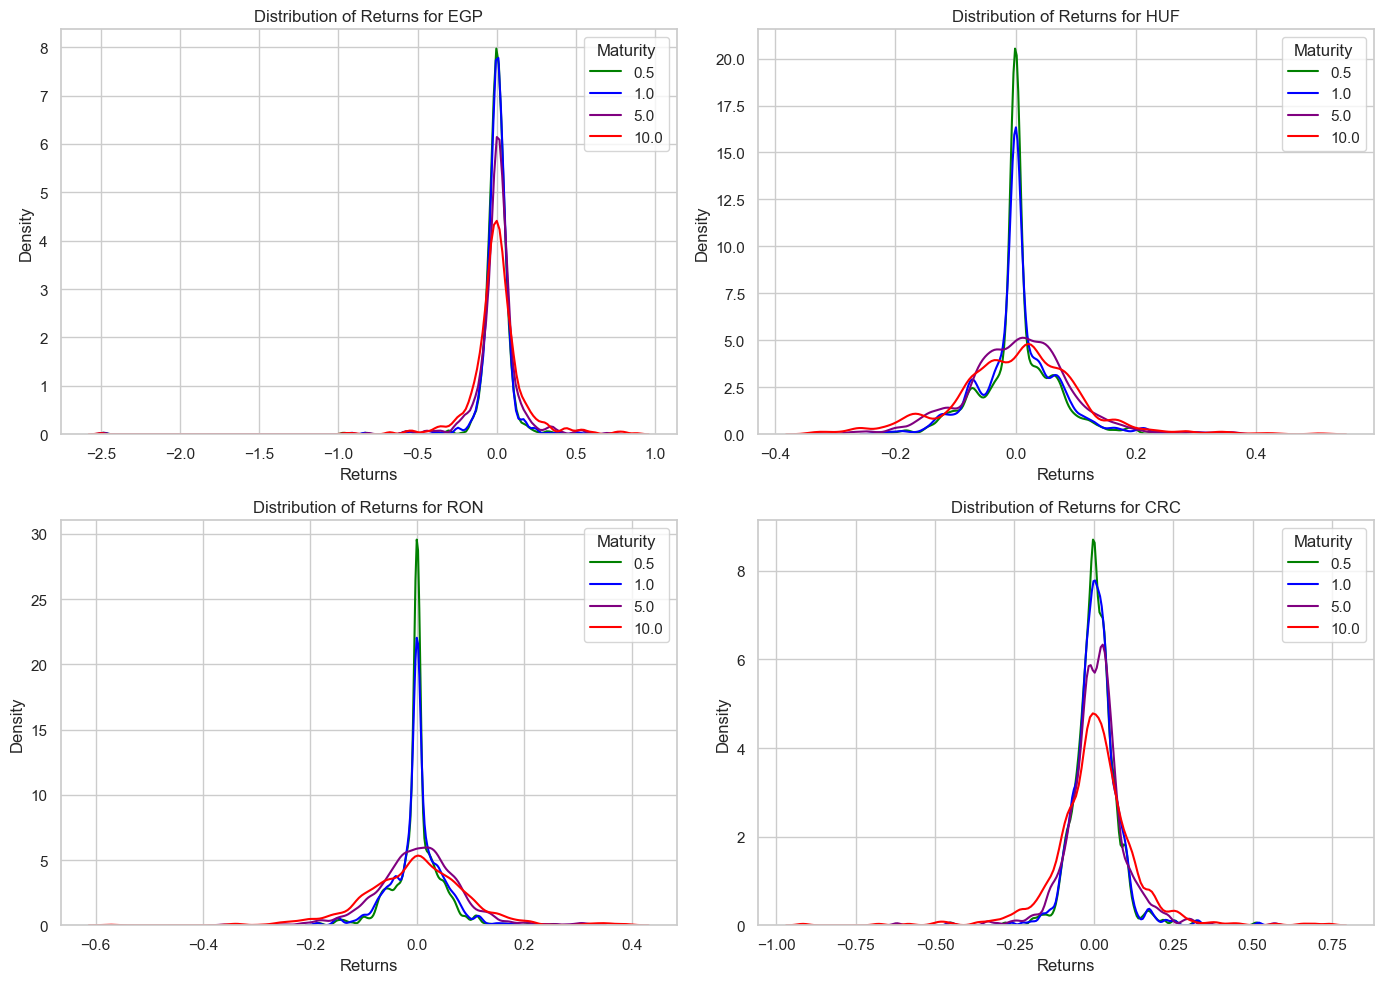

In [37]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

currencies = ["EGP", "HUF", "RON", "CRC"]
for i, currency in enumerate(currencies):
    ax = axs[i//2, i%2]
    for maturity in maturities:
        sns.kdeplot(returns_strats[f"{currency} - {str(maturity)}Y"], ax=ax, label=f"{maturity}", bw_adjust=0.5)
    ax.set_title(f"Distribution of Returns for {currency}")
    ax.legend(title="Maturity")
    ax.set_xlabel("Returns")
    ax.set_ylabel("Density")

plt.tight_layout()
plt.show()

As discussed before, using skewness and kurtosis, we can see that the EGP strategies have a very negative skew and a very high kurtosis, which is not good for our carry trade. Let's not get tricked by the axis values, the distribution of EGP looks thin because of the scaling of our axis, but it is not, compared to the other currencies.

Some CRC strategies are also negatively skewed while RON strategies and HUF strategies are positively skewed. They all have relatively moderate kurtosis, with larger values for CRC.

#### 4.5. Correlation Analysis

In the early stages of our work, we looked at the correlation between the different currencies, and we identified that CRC was the least correlated with the other currencies. Let's now look at the correlation between the different strategies to see if we can identify some patterns.

<Axes: >

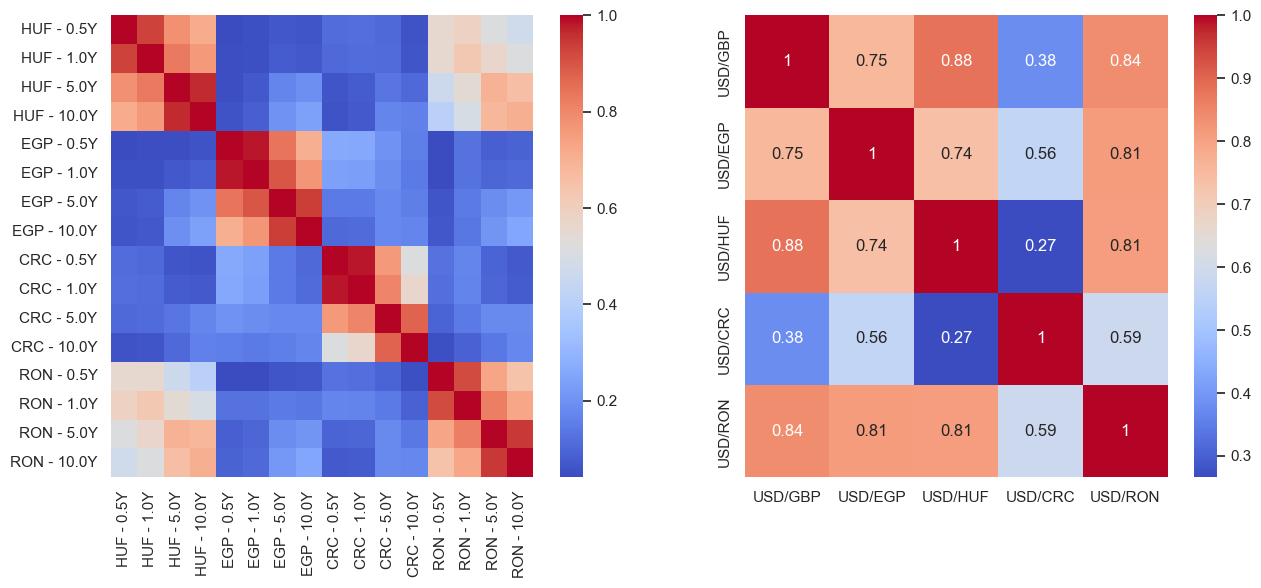

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

sns.heatmap(returns_strats.corr(), annot=False, cmap='coolwarm', ax=axs[0])
sns.heatmap(currency_fx.corr(), annot=True, cmap='coolwarm', ax=axs[1])

Looking at this heatmap, we can make three observations. The first one is that within a currency, the different strategies are very correlated. We use different swap rate maturities to generate our signals and to use as coupon rates, but all those strategies show very high correlation. The second observation we can make is that in general, the strategies on different currencies are not very correlated. Even if we saw that foreign exchange rates were usually very correlated. The last observation is that for HUF and RON, we find higher correlation coefficients between the different strategies. This could be linked to the fact that those two currencies are from countries in Europe that are geographically close and have similar economic environments. They share similar dynamics of swap rates and foreign exchange rates, which could explain why the strategies on those two currencies are more correlated than the others.

#### 4.6. Market Risk Factors Analysis

Finally, when analyzing carry trade strategies from a US-based perspective, considering market risk factors is crucial. These factors can significantly influence the performance of carry trades, affecting the interest rate differentials that are the core of carry trade profitability.

What we can look at is Market Sentiment and Risk Appetite through VIX Index. The general mood of the market, whether risk-averse or risk-seeking, can impact carry trade performance. In periods of high risk appetite, carry trades tend to perform well, as investors are more willing to take on the risk for higher returns. Conversely, in risk-averse environments, such as during financial crises, carry trades can suffer as investors flock to safer assets. US market sentiment, reflected through stock market performance, VIX (a volatility index), and other sentiment indicators, can be a proxy for global risk appetite.

In [39]:
VIX_Index = pd.read_csv('./Homework_5/VIX_History.csv')
VIX_Index.columns = VIX_Index.columns.str.lower()
VIX_Index['date'] = pd.to_datetime(VIX_Index['date'])
VIX_Index = VIX_Index.set_index('date')
VIX_Index = VIX_Index.loc['2012':]

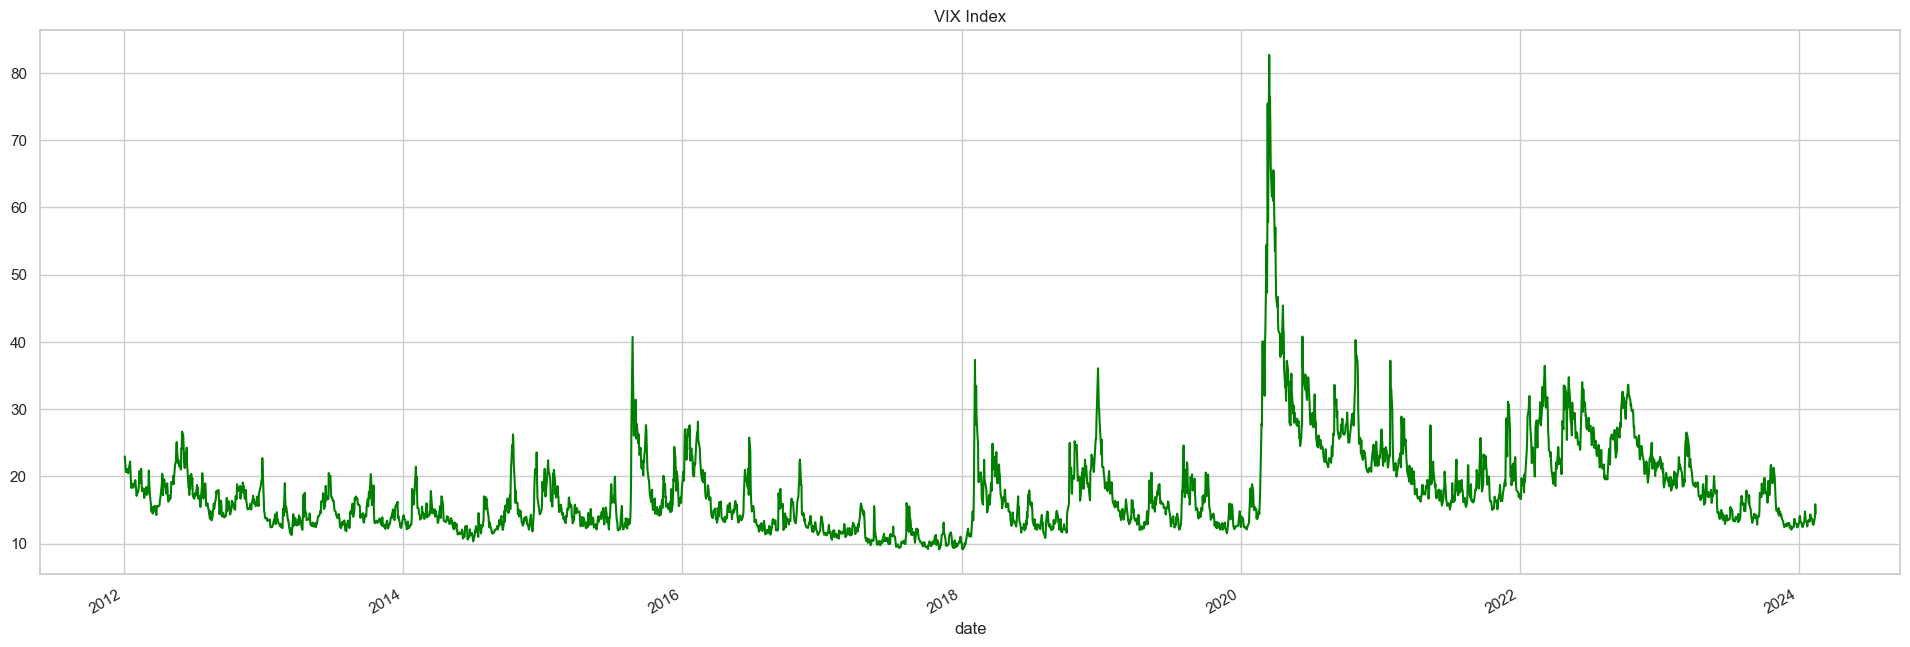

In [40]:
VIX_Index['close'].plot(figsize=(24, 8))
plt.title('VIX Index')
plt.show()

In [41]:
correlation_matrix_VIX = returns_strats.corrwith(VIX_Index['close']).to_frame('Correlation with VIX').applymap(lambda x: f'{x:.2%}')
correlation_matrix_VIX

Correlation with VIX
HUF - 0.5Y                 0.54%
HUF - 1.0Y                -0.12%
HUF - 5.0Y                -5.70%
HUF - 10.0Y               -5.51%
EGP - 0.5Y                 1.06%
EGP - 1.0Y                -1.30%
EGP - 5.0Y                -7.83%
EGP - 10.0Y              -10.93%
CRC - 0.5Y                 8.49%
CRC - 1.0Y                 7.20%
CRC - 5.0Y                 0.51%
CRC - 10.0Y                0.93%
RON - 0.5Y                 5.50%
RON - 1.0Y                 3.69%
RON - 5.0Y                -0.02%
RON - 10.0Y               -1.95%

Running a correlation analysis on our strategies against the VIX index, we can see that we get different results. Let's just emphasize the fact that the VIX Index is inversely related to the S&P 500 – when the price of the VIX goes up, the price of the S&P 500 usually goes down, and vice versa. It generates a 30-day forward projection of volatility. Volatility, or how fast prices change, is often seen as a way to gauge market sentiment, and in particular the degree of fear among market participants.

Here is how we might interpret the correlations presented:

- **Positive Correlation with VIX**: A positive correlation means that as the VIX increases (indicating higher market volatility and risk aversion), the returns of the carry trade strategy also tend to increase. This is somewhat unusual for carry trades, as they typically perform poorly during times of high volatility and risk aversion. A positive correlation could suggest that the strategy is taking on riskier positions that happen to align with market stress periods or that there's some form of hedging strategy in place that benefits from increased volatility.

- **Negative Correlation with VIX**: A negative correlation indicates that when the VIX goes up, the returns of the carry trade strategy tend to go down. This is a more typical relationship for carry trades since these strategies generally profit from stable and low-volatility environments where the interest rate differential can be exploited without disruptive market movements. Negative correlations suggest that the strategy is likely to incur losses during periods of high volatility and risk aversion.

Looking at the specific correlations:

- **HUF (Hungarian Forint)**: The shorter-term HUF strategy (0.5Y) has a slight positive correlation, while the longer-term strategies have negative correlations, with the 5Y and 10Y maturities showing more significant negative correlations. This suggests that longer-term HUF carry trades may suffer during periods of market stress.

- **EGP (Egyptian Pound)**: There's a strong negative correlation for longer maturities (5Y and 10Y), suggesting these strategies are likely to perform poorly during volatile market conditions. Interestingly, the short-term 0.5Y strategy has a positive correlation, which is atypical and could imply some specific market dynamic or strategy component at play.

- **CRC (Costa Rican Colón)**: The correlations here are mixed, with the short-term 0.5Y and 1Y strategies showing strong positive correlations, while the 5Y and 10Y strategies have correlations close to zero, indicating no clear relationship with the VIX.

- **RON (Romanian Leu)**: The RON strategies exhibit a decreasing trend in correlation with VIX as we move from short-term to long-term maturities. The short-term strategies have a strong positive correlation, suggesting they might be riskier and potentially more profitable in volatile times, while the longer-term strategies approach a neutral to negative correlation.

These correlations provide insight into how each carry trade strategy might be expected to perform in relation to market volatility. Generally, carry trades are expected to do better in calm markets, so a negative correlation with the VIX is typical. Positive correlations are less common and might reflect a unique aspect of the strategy or underlying currency dynamics.

In [42]:
currency_fx_change = currency_fx.diff()
exchange_rate_volatility = currency_fx_change.std()

exchange_rate_volatility.to_frame('Volatility').T.applymap(lambda x: f'{x:.2%}')

USD/GBP USD/EGP  USD/HUF  USD/CRC USD/RON
Volatility   0.32%  10.27%  176.46%  262.30%   1.87%

**USD/GBP (0.32%)**: This low volatility indicates a relatively stable currency pair. For carry trades, this suggests that the risk of adverse movements in the GBP relative to the USD is lower compared to more volatile pairs. Stable currency pairs are often preferred for carry trades because they offer more predictability in returns. However, the interest rate differential between the two currencies also plays a significant role.

**USD/EGP (10.27%)**: The higher volatility here suggests that the Egyptian Pound experiences more significant price movements relative to the USD. In a carry trade, this means there's a higher risk that the EGP could move unfavorably against the USD, potentially leading to larger losses. Carry traders need to be cautious with such pairs and possibly expect a higher interest rate differential to compensate for the increased risk.

**USD/HUF (176.46%) and USD/CRC (262.30%)**: These extremely high volatility figures seem unusual and could indicate hyperinflation, or a highly unstable currency situation. In normal circumstances, such extreme volatility would make carry trades highly risky and speculative, as the potential for large adverse movements could far outweigh the potential benefits from interest rate differentials.

**USD/RON (1.87%)**: This indicates moderate volatility, suggesting that the Romanian Leu has more stable movements relative to the USD than the EGP but is less stable than the GBP. For carry trades, this implies a moderate level of risk where traders might expect a moderate interest rate differential to justify the risk.

Volatility is directly related to market risk in carry trades because it measures the unpredictability of exchange rate movements that can directly impact the profitability of a carry trade. High volatility increases the risk of a trade, as the potential for wide swings in exchange rates can result in large, rapid losses, while low volatility suggests more stable returns. However, it's important to also consider other factors like interest rate differentials, economic fundamentals, and geopolitical risks when evaluating carry trade opportunities. Carry traders often seek to balance the higher interest income against potential losses due to currency depreciation, which is more likely when volatility is high.

### 5. Conclusion

Throughout our comprehensive analysis, we embarked on a multifaceted exploration of carry trade strategies, leveraging a dataset that spans multiple currencies and swap rates. The journey began with an aggregation of financial data from Quandl, encompassing FX rates for notable currency pairs, UK overnight index swaps (OIS), and associated swap yield curves. The data, once gathered, was meticulously transformed and tailored to facilitate the pricing of bonds necessary for our carry trade strategy.

The crux of our carry trade strategy was to capitalize on the interest rate differentials between the borrowing currency (GBP) and various lending currencies (EGP, HUF, CRC, RON). This strategy's essence was manifested through the simulated fixed-float swaps, normalized to a notional of USD 10 million. Our approach was strategic, employing the CarryTrade class to orchestrate the execution of trades, encompassing the meticulous calculation of cash flows and profit and loss (PnL) in both borrowing and lending legs.

The analysis delved into performance metrics and risk assessments, revealing a striking dichotomy in the results. The HUF - 5.0Y strategy emerged as the optimal choice in terms of risk-reward balance, boasting the highest mean return and a commendable Sharpe Ratio, indicative of its efficient management of volatility. However, it was the CRC - 1.0Y strategy that ultimately captured the title of the most balanced trade. Its positive skew and moderate excess kurtosis signified a harmonious blend of profitability and risk mitigation. This nuanced understanding of performance and risk was further enriched by examining skewness and kurtosis, which offered insights into the distribution characteristics of returns, essential for informed investment decisions.

In the latter stages of our analysis, we scrutinized the correlation between our strategies and market sentiment, represented by the VIX Index. The findings were intriguing; certain strategies, notably those involving HUF and RON, displayed a negative correlation, suggesting vulnerability during volatile market conditions. Conversely, the CRC strategy, with its short-term maturities, exhibited a strong positive correlation, hinting at its potential profitability amidst market turbulence.

Our conclusion is thus: the CRC - 1.0Y strategy stands as the paramount choice for a carry trade, striking an exemplary equilibrium between yield and safety. It adeptly navigates through market volatilities, aligning with US market sentiment, and offers a robust hedge against the unpredictable tides of global finance. This strategy not only showcases resilience in the face of market vicissitudes but also promises a lucrative return on investment, a beacon for those seeking a prudent yet profitable venture in the dynamic world of currency swaps.